In [204]:
# =============================================================================
# PASO 1: Configuración e importaciones
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Configuración de rutas
DATA_DIR = Path("../data/milano")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# Listar archivos disponibles
csv_files = sorted(DATA_DIR.glob("*.csv"))
print(f"Archivos CSV encontrados: {len(csv_files)}")
for f in csv_files:
    print(f"  - {f.name}")

Archivos CSV encontrados: 7
  - sms-call-internet-mi-2013-11-01.csv
  - sms-call-internet-mi-2013-11-02.csv
  - sms-call-internet-mi-2013-11-03.csv
  - sms-call-internet-mi-2013-11-04.csv
  - sms-call-internet-mi-2013-11-05.csv
  - sms-call-internet-mi-2013-11-06.csv
  - sms-call-internet-mi-2013-11-07.csv


## Paso 2: Función para cargar y agregar CSVs por chunks
Leemos cada CSV en chunks de 500k filas, filtramos `countrycode==39` (Italia), y agregamos por hora.

In [205]:
# =============================================================================
# PASO 2: Función para cargar y procesar CSVs por chunks
# =============================================================================

def load_and_aggregate_csv(filepath: Path, chunksize: int = 500_000, 
                           country_filter: int = 39) -> pd.DataFrame:
    """
    Carga un CSV grande por chunks, filtra por countrycode y agrega por hora.
    
    Args:
        filepath: Ruta al archivo CSV
        chunksize: Tamaño del chunk para lectura incremental
        country_filter: Código de país a filtrar (39 = Italia)
    
    Returns:
        DataFrame agregado por hora con columnas:
        datetime, sms_total, call_total, internet
    """
    # Columnas necesarias
    usecols = ['datetime', 'CellID', 'countrycode', 'smsin', 'smsout', 
               'callin', 'callout', 'internet']
    
    # Acumulador para chunks agregados
    hourly_data = []
    total_rows = 0
    filtered_rows = 0
    
    # Leer por chunks
    for chunk in pd.read_csv(filepath, chunksize=chunksize, usecols=usecols):
        total_rows += len(chunk)
        
        # Filtrar por countrycode
        chunk = chunk[chunk['countrycode'] == country_filter].copy()
        filtered_rows += len(chunk)
        
        if len(chunk) == 0:
            continue
        
        # Convertir datetime
        chunk['datetime'] = pd.to_datetime(chunk['datetime'], format='%Y-%m-%d %H:%M:%S')
        
        # Reemplazar NaNs por 0 en columnas numéricas
        numeric_cols = ['smsin', 'smsout', 'callin', 'callout', 'internet']
        chunk[numeric_cols] = chunk[numeric_cols].fillna(0)
        
        # Extraer hora para agrupación
        chunk['hour'] = chunk['datetime'].dt.floor('h')
        
        # Agregar por hora (suma total de toda la ciudad)
        agg = chunk.groupby('hour').agg({
            'smsin': 'sum',
            'smsout': 'sum',
            'callin': 'sum',
            'callout': 'sum',
            'internet': 'sum'
        }).reset_index()
        
        hourly_data.append(agg)
    
    # Concatenar todos los chunks
    if not hourly_data:
        raise ValueError(f"No se encontraron datos con countrycode={country_filter}")
    
    result = pd.concat(hourly_data, ignore_index=True)
    
    # Re-agregar por si hay duplicados de hora entre chunks
    result = result.groupby('hour').agg({
        'smsin': 'sum',
        'smsout': 'sum',
        'callin': 'sum',
        'callout': 'sum',
        'internet': 'sum'
    }).reset_index()
    
    # Crear columnas totales
    result['sms_total'] = result['smsin'] + result['smsout']
    result['call_total'] = result['callin'] + result['callout']
    
    # Renombrar columna hora a datetime
    result = result.rename(columns={'hour': 'datetime'})
    
    # Ordenar por datetime
    result = result.sort_values('datetime').reset_index(drop=True)
    
    print(f"  Archivo: {filepath.name}")
    print(f"    Filas totales: {total_rows:,}")
    print(f"    Filas filtradas (country={country_filter}): {filtered_rows:,}")
    print(f"    Horas únicas: {len(result)}")
    
    return result[['datetime', 'sms_total', 'call_total', 'internet']]

# Mostrar estructura esperada
print("Función de carga definida correctamente.")

Función de carga definida correctamente.


## Paso 3: Procesar los 7 días y crear dataset semanal
Cargamos cada CSV, agregamos por hora, y concatenamos en un único DataFrame semanal (~168 filas).

In [206]:
# =============================================================================
# PASO 3: Procesar todos los CSVs y crear dataset semanal
# =============================================================================

print("Procesando archivos CSV de Milano...")
print("=" * 60)

daily_dataframes = []

for csv_file in csv_files:
    df_day = load_and_aggregate_csv(csv_file, chunksize=500_000, country_filter=39)
    daily_dataframes.append(df_day)
    print()

# Concatenar todos los días
df_week = pd.concat(daily_dataframes, ignore_index=True)
df_week = df_week.sort_values('datetime').reset_index(drop=True)

print("=" * 60)
print(f"\nDataset semanal creado:")
print(f"  Filas totales: {len(df_week)}")
print(f"  Rango temporal: {df_week['datetime'].min()} - {df_week['datetime'].max()}")
print(f"  Días únicos: {df_week['datetime'].dt.date.nunique()}")

# Verificar completitud (esperamos 24 horas × 7 días = 168)
expected_hours = 24 * 7
print(f"\n  Horas esperadas: {expected_hours}")
print(f"  Horas obtenidas: {len(df_week)}")
print(f"  Completitud: {len(df_week)/expected_hours*100:.1f}%")

# Mostrar primeras filas
df_week.head(10)

Procesando archivos CSV de Milano...
  Archivo: sms-call-internet-mi-2013-11-01.csv
    Filas totales: 1,891,928
    Filas filtradas (country=39): 240,000
    Horas únicas: 24

  Archivo: sms-call-internet-mi-2013-11-02.csv
    Filas totales: 1,847,331
    Filas filtradas (country=39): 240,000
    Horas únicas: 24

  Archivo: sms-call-internet-mi-2013-11-03.csv
    Filas totales: 1,828,063
    Filas filtradas (country=39): 239,999
    Horas únicas: 24

  Archivo: sms-call-internet-mi-2013-11-04.csv
    Filas totales: 2,299,544
    Filas filtradas (country=39): 239,997
    Horas únicas: 24

  Archivo: sms-call-internet-mi-2013-11-05.csv
    Filas totales: 2,397,759
    Filas filtradas (country=39): 239,999
    Horas únicas: 24

  Archivo: sms-call-internet-mi-2013-11-06.csv
    Filas totales: 2,417,156
    Filas filtradas (country=39): 239,998
    Horas únicas: 24

  Archivo: sms-call-internet-mi-2013-11-07.csv
    Filas totales: 2,407,384
    Filas filtradas (country=39): 239,999
    H

,datetime,sms_total,call_total,internet
0,2013-11-01 00:00:00,185520.9174,95752.6766,3.616666e+06
1,2013-11-01 01:00:00,127256.4043,57476.4304,3.081744e+06
2,2013-11-01 02:00:00,91950.7496,40907.1086,2.664574e+06
3,2013-11-01 03:00:00,74326.1974,31166.0529,2.361885e+06
4,2013-11-01 04:00:00,56720.5141,24728.4194,2.154030e+06
5,2013-11-01 05:00:00,47382.0227,22288.4091,2.022302e+06
6,2013-11-01 06:00:00,55615.7346,27169.0313,2.063274e+06
7,2013-11-01 07:00:00,93827.5842,55252.2706,2.336573e+06
8,2013-11-01 08:00:00,228643.9638,146520.0322,2.814181e+06
9,2013-11-01 09:00:00,300091.7655,311247.1183,3.449482e+06


## Paso 4: Calcular ratios y normalizar features
Añadimos ratios (`sms_ratio`, `call_ratio`, `data_ratio`) y normalizamos con StandardScaler para el clustering.

In [207]:
# =============================================================================
# PASO 4: Calcular ratios y normalizar features
# =============================================================================

# Epsilon para evitar división por cero
EPS = 1e-6

# Calcular ratios
df_week['sms_ratio'] = df_week['sms_total'] / (df_week['sms_total'] + df_week['call_total'] + EPS)
df_week['call_ratio'] = df_week['call_total'] / (df_week['sms_total'] + df_week['call_total'] + EPS)
df_week['data_ratio'] = df_week['internet'] / (df_week['internet'] + df_week['call_total'] + df_week['sms_total'] + EPS)

# Extraer características temporales útiles
df_week['hour_of_day'] = df_week['datetime'].dt.hour
df_week['day_of_week'] = df_week['datetime'].dt.dayofweek
df_week['day_name'] = df_week['datetime'].dt.day_name()
df_week['is_weekend'] = df_week['day_of_week'].isin([5, 6]).astype(int)

# Features para clustering
clustering_features = ['sms_total', 'call_total', 'internet', 'sms_ratio', 'call_ratio', 'data_ratio']

# Normalizar con StandardScaler
scaler = StandardScaler()
df_week_scaled = scaler.fit_transform(df_week[clustering_features])

# Crear DataFrame con features normalizadas
df_scaled = pd.DataFrame(
    df_week_scaled,
    columns=[f'{col}_norm' for col in clustering_features]
)

# Añadir al dataset original
for col in df_scaled.columns:
    df_week[col] = df_scaled[col].values

print("Features calculadas y normalizadas:")
print(f"  Ratios: sms_ratio, call_ratio, data_ratio")
print(f"  Temporales: hour_of_day, day_of_week, day_name, is_weekend")
print(f"  Normalizadas: {list(df_scaled.columns)}")

# Estadísticas descriptivas
print("\n" + "=" * 60)
print("Estadísticas de las features originales:")
df_week[clustering_features].describe().round(2)

Features calculadas y normalizadas:
  Ratios: sms_ratio, call_ratio, data_ratio
  Temporales: hour_of_day, day_of_week, day_name, is_weekend
  Normalizadas: ['sms_total_norm', 'call_total_norm', 'internet_norm', 'sms_ratio_norm', 'call_ratio_norm', 'data_ratio_norm']

Estadísticas de las features originales:


,sms_total,call_total,internet,sms_ratio,call_ratio,data_ratio
count,168.00,168.00,168.00,168.00,168.00,168.00
mean,329523.60,371424.63,4079987.26,0.56,0.44,0.88
std,222492.52,337871.75,1405443.57,0.13,0.13,0.07
min,26332.61,9072.80,1696447.66,0.39,0.23,0.78
25%,93358.38,43585.59,2759484.56,0.44,0.30,0.82
50%,318873.81,309192.62,4119453.83,0.52,0.48,0.87
75%,562983.42,732565.65,5463876.77,0.70,0.56,0.95
max,702242.95,1014079.64,6275085.81,0.77,0.61,0.98


---
# PARTE 2: Clustering por Servicio con K Óptimo (Estilo experiments.ipynb)

En esta sección realizamos clustering **individual por cada servicio** (empezando con Internet/Datos) usando:
- **Selección robusta de K**: 30 repeticiones de K-Means para cada K, promediando métricas
- **Mapeo dinámico a perfiles**: Bajo, Normal, Alto (basado en media del servicio)
- **Visualizaciones duales**: Escala lineal + logarítmica (como en experiments.ipynb)

Este enfoque se alinea con el análisis realizado en `clustering/experiments.ipynb` para consistencia metodológica.

## Paso 12: Preparar datos para clustering por servicio
Creamos el perfil diario (24 horas) y preparamos los datos para clustering individual por servicio.

In [208]:
# =============================================================================
# PASO 12: Preparar datos para clustering por servicio
# =============================================================================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("=" * 80)
print("PREPARACIÓN DE DATOS PARA CLUSTERING POR SERVICIO")
print("=" * 80)

# Agrupar por hora del día, calculando estadísticas para cada servicio
df_daily = df_week.groupby('hour_of_day').agg({
    'sms_total': ['mean', 'std', 'min', 'max'],
    'call_total': ['mean', 'std', 'min', 'max'],
    'internet': ['mean', 'std', 'min', 'max'],
    'sms_ratio': 'mean',
    'call_ratio': 'mean',
    'data_ratio': 'mean'
}).reset_index()

# Flatten column names
df_daily.columns = ['_'.join(col).strip('_') for col in df_daily.columns]

# Calcular coeficiente de variación (CV = std/mean)
for service in ['sms_total', 'call_total', 'internet']:
    df_daily[f'{service}_cv'] = df_daily[f'{service}_std'] / (df_daily[f'{service}_mean'] + 1e-6)

print(f"\nPerfil diario creado:")
print(f"  Horas: {len(df_daily)} (0-23)")
print(f"  Días promediados: {df_week['datetime'].dt.date.nunique()}")

# Estadísticas por servicio
print(f"\nEstadísticas de INTERNET (Datos):")
print(f"  Media total:  {df_daily['internet_mean'].sum():,.0f}")
print(f"  Media/hora:   {df_daily['internet_mean'].mean():,.0f}")
print(f"  Máx hora:     {df_daily['internet_mean'].max():,.0f} (hora {df_daily.loc[df_daily['internet_mean'].idxmax(), 'hour_of_day']})")
print(f"  Mín hora:     {df_daily['internet_mean'].min():,.0f} (hora {df_daily.loc[df_daily['internet_mean'].idxmin(), 'hour_of_day']})")
print(f"  CV promedio:  {df_daily['internet_cv'].mean():.2%}")

# Mostrar perfil de Internet
print("\n📊 Perfil horario de INTERNET:")
display(df_daily[['hour_of_day', 'internet_mean', 'internet_std', 'internet_cv']].round(2))

PREPARACIÓN DE DATOS PARA CLUSTERING POR SERVICIO

Perfil diario creado:
  Horas: 24 (0-23)
  Días promediados: 7

Estadísticas de INTERNET (Datos):
  Media total:  97,919,694
  Media/hora:   4,079,987
  Máx hora:     5,303,077 (hora 17)
  Mín hora:     1,978,550 (hora 5)
  CV promedio:  15.25%

📊 Perfil horario de INTERNET:


,hour_of_day,internet_mean,internet_std,internet_cv
0,0,3347633.55,192886.27,0.06
1,1,2789541.17,183428.43,0.07
2,2,2405004.75,162482.68,0.07
3,3,2148474.01,159929.44,0.07
4,4,1999222.45,159129.63,0.08
5,5,1978550.38,179664.80,0.09
6,6,2224966.86,342023.58,0.15
7,7,3067714.49,899137.60,0.29
8,8,4008187.82,1352073.30,0.34
9,9,4517263.95,1211428.09,0.27


## Paso 12b: Análisis Exploratorio - Distribución de INTERNET
Analizamos la distribución del tráfico de Internet: histogramas, ajuste de distribuciones, tests de normalidad y correlaciones.

In [209]:
# =============================================================================
# PASO 12b: ANÁLISIS EXPLORATORIO - DISTRIBUCIÓN DE INTERNET
# =============================================================================
from scipy import stats
from scipy.stats import shapiro, normaltest, kstest, expon, norm, lognorm

print("=" * 80)
print("ANÁLISIS DE DISTRIBUCIÓN - INTERNET (DATOS)")
print("=" * 80)

# Datos a analizar
internet_values = df_daily['internet_mean'].values
internet_std_values = df_daily['internet_std'].values

# =============================================================================
# 1. ESTADÍSTICAS DESCRIPTIVAS
# =============================================================================
print("\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
print("-" * 60)

stats_desc = {
    'Media': np.mean(internet_values),
    'Mediana': np.median(internet_values),
    'Desv. Std': np.std(internet_values),
    'Varianza': np.var(internet_values),
    'Mínimo': np.min(internet_values),
    'Máximo': np.max(internet_values),
    'Rango': np.max(internet_values) - np.min(internet_values),
    'IQR (Q3-Q1)': np.percentile(internet_values, 75) - np.percentile(internet_values, 25),
    'Asimetría (Skewness)': stats.skew(internet_values),
    'Curtosis': stats.kurtosis(internet_values),
    'Coef. Variación': np.std(internet_values) / np.mean(internet_values)
}

for stat, value in stats_desc.items():
    if 'Media' in stat or 'Mediana' in stat or 'Mínimo' in stat or 'Máximo' in stat or 'Rango' in stat or 'IQR' in stat:
        print(f"   {stat:20s}: {value:>15,.0f}")
    else:
        print(f"   {stat:20s}: {value:>15.4f}")

# Interpretación de asimetría
skew_val = stats_desc['Asimetría (Skewness)']
if skew_val > 0.5:
    skew_interp = "Asimetría positiva (cola derecha larga)"
elif skew_val < -0.5:
    skew_interp = "Asimetría negativa (cola izquierda larga)"
else:
    skew_interp = "Distribución aproximadamente simétrica"
print(f"\n   → Interpretación: {skew_interp}")

# =============================================================================
# 2. TESTS DE NORMALIDAD
# =============================================================================
print("\n📊 TESTS DE NORMALIDAD:")
print("-" * 60)

# Shapiro-Wilk (mejor para muestras pequeñas n<50)
stat_shapiro, p_shapiro = shapiro(internet_values)
print(f"   Shapiro-Wilk:     W = {stat_shapiro:.4f}, p-value = {p_shapiro:.6f}")

# D'Agostino-Pearson (basado en skewness y kurtosis)
stat_dagostino, p_dagostino = normaltest(internet_values)
print(f"   D'Agostino:       K² = {stat_dagostino:.4f}, p-value = {p_dagostino:.6f}")

# Kolmogorov-Smirnov vs normal
stat_ks, p_ks = kstest(internet_values, 'norm', args=(np.mean(internet_values), np.std(internet_values)))
print(f"   Kolmogorov-Smirnov: D = {stat_ks:.4f}, p-value = {p_ks:.6f}")

alpha = 0.05
print(f"\n   Nivel de significancia: α = {alpha}")
if p_shapiro < alpha:
    print(f"   ❌ Shapiro-Wilk: RECHAZAR normalidad (p < {alpha})")
else:
    print(f"   ✅ Shapiro-Wilk: No se rechaza normalidad (p ≥ {alpha})")

# =============================================================================
# 3. AJUSTE DE DISTRIBUCIONES
# =============================================================================
print("\n📊 AJUSTE DE DISTRIBUCIONES:")
print("-" * 60)

# Ajustar diferentes distribuciones
distribuciones = {}

# Normal
params_norm = norm.fit(internet_values)
distribuciones['Normal'] = {'params': params_norm, 'dist': norm}

# Exponencial
params_exp = expon.fit(internet_values)
distribuciones['Exponencial'] = {'params': params_exp, 'dist': expon}

# Log-normal
params_lognorm = lognorm.fit(internet_values)
distribuciones['Log-Normal'] = {'params': params_lognorm, 'dist': lognorm}

# Calcular bondad de ajuste (Kolmogorov-Smirnov)
print("\n   Bondad de ajuste (Kolmogorov-Smirnov):")
mejor_dist = None
mejor_pvalue = 0

for nombre, info in distribuciones.items():
    stat, pvalue = kstest(internet_values, info['dist'].cdf, args=info['params'])
    info['ks_stat'] = stat
    info['ks_pvalue'] = pvalue
    
    estado = "✅" if pvalue > 0.05 else "❌"
    print(f"   {estado} {nombre:15s}: D = {stat:.4f}, p-value = {pvalue:.6f}")
    
    if pvalue > mejor_pvalue:
        mejor_pvalue = pvalue
        mejor_dist = nombre

print(f"\n   🏆 Mejor ajuste: {mejor_dist} (p-value = {mejor_pvalue:.4f})")

ANÁLISIS DE DISTRIBUCIÓN - INTERNET (DATOS)

📊 ESTADÍSTICAS DESCRIPTIVAS:
------------------------------------------------------------
   Media               :       4,079,987
   Mediana             :       4,576,118
   Desv. Std           :    1208319.1456
   Varianza            : 1460035157698.2383
   Mínimo              :       1,978,550
   Máximo              :       5,303,077
   Rango               :       3,324,527
   IQR (Q3-Q1)         :       2,161,788
   Asimetría (Skewness):         -0.6164
   Curtosis            :         -1.2094
   Coef. Variación     :          0.2962

   → Interpretación: Asimetría negativa (cola izquierda larga)

📊 TESTS DE NORMALIDAD:
------------------------------------------------------------
   Shapiro-Wilk:     W = 0.8373, p-value = 0.001282
   D'Agostino:       K² = 5.9518, p-value = 0.051003
   Kolmogorov-Smirnov: D = 0.1914, p-value = 0.302974

   Nivel de significancia: α = 0.05
   ❌ Shapiro-Wilk: RECHAZAR normalidad (p < 0.05)

📊 AJUSTE DE DIS

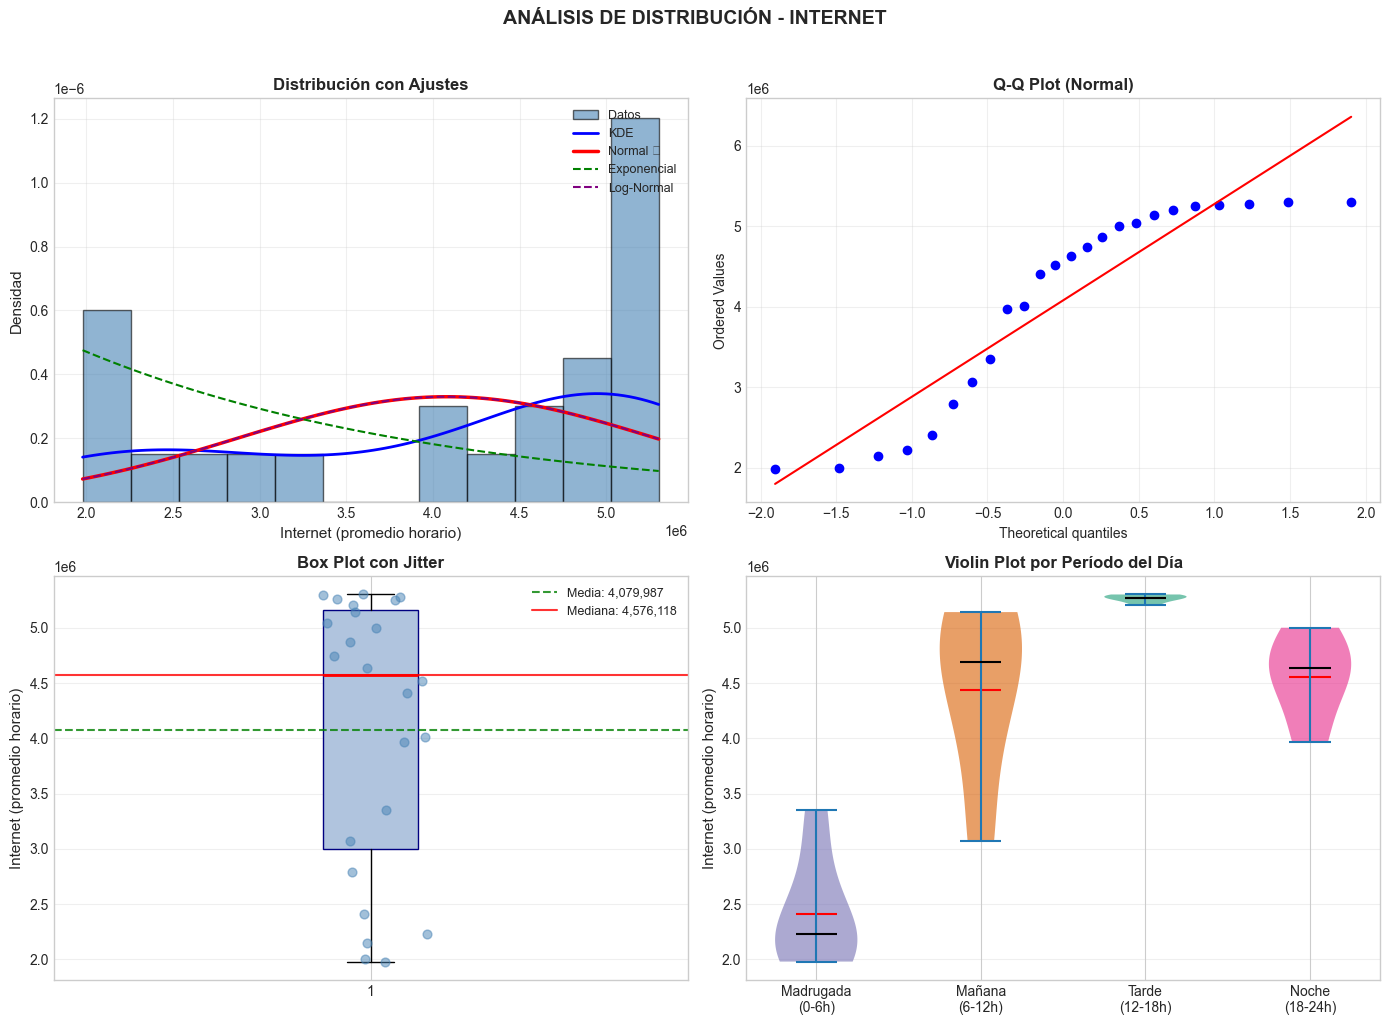


📊 INTERPRETACIÓN:
------------------------------------------------------------
   • El histograma muestra la distribución empírica de los datos
   • La mejor distribución teórica es: Normal
   • El Q-Q Plot evalúa visualmente la normalidad
   • El Violin Plot revela diferencias entre períodos del día


In [210]:
# =============================================================================
# 4. VISUALIZACIÓN DE DISTRIBUCIONES
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 4.1 Histograma con KDE y ajustes de distribución
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(internet_values, bins=12, density=True, alpha=0.6, 
                             color='steelblue', edgecolor='black', label='Datos')

# Agregar KDE
from scipy.stats import gaussian_kde
kde = gaussian_kde(internet_values)
x_kde = np.linspace(internet_values.min(), internet_values.max(), 100)
ax1.plot(x_kde, kde(x_kde), 'b-', lw=2, label='KDE')

# Agregar distribuciones ajustadas
x_fit = np.linspace(internet_values.min(), internet_values.max(), 100)
colores_dist = {'Normal': 'red', 'Exponencial': 'green', 'Log-Normal': 'purple'}

for nombre, info in distribuciones.items():
    y_fit = info['dist'].pdf(x_fit, *info['params'])
    linestyle = '-' if nombre == mejor_dist else '--'
    lw = 2.5 if nombre == mejor_dist else 1.5
    ax1.plot(x_fit, y_fit, color=colores_dist[nombre], linestyle=linestyle, 
             lw=lw, label=f'{nombre}' + (' ⭐' if nombre == mejor_dist else ''))

ax1.set_xlabel('Internet (promedio horario)', fontsize=11)
ax1.set_ylabel('Densidad', fontsize=11)
ax1.set_title('Distribución con Ajustes', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# 4.2 Q-Q Plot (Normal)
ax2 = axes[0, 1]
stats.probplot(internet_values, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot (Normal)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 4.3 Box Plot con detalles
ax3 = axes[1, 0]
bp = ax3.boxplot(internet_values, patch_artist=True, vert=True)
bp['boxes'][0].set_facecolor('lightsteelblue')
bp['boxes'][0].set_edgecolor('navy')
bp['medians'][0].set_color('red')
bp['medians'][0].set_linewidth(2)

# Agregar puntos individuales (jitter)
x_jitter = np.random.normal(1, 0.04, size=len(internet_values))
ax3.scatter(x_jitter, internet_values, alpha=0.5, color='steelblue', s=40, zorder=3)

# Marcar valores específicos
ax3.axhline(y=np.mean(internet_values), color='green', linestyle='--', 
            label=f'Media: {np.mean(internet_values):,.0f}', alpha=0.8)
ax3.axhline(y=np.median(internet_values), color='red', linestyle='-', 
            label=f'Mediana: {np.median(internet_values):,.0f}', alpha=0.8)

ax3.set_ylabel('Internet (promedio horario)', fontsize=11)
ax3.set_title('Box Plot con Jitter', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# 4.4 Violin Plot por período del día
ax4 = axes[1, 1]

# Crear grupos por período
df_periodos = df_daily.copy()
df_periodos['periodo'] = pd.cut(
    df_periodos['hour_of_day'],
    bins=[-1, 6, 12, 18, 24],
    labels=['Madrugada\n(0-6h)', 'Mañana\n(6-12h)', 'Tarde\n(12-18h)', 'Noche\n(18-24h)']
)

# Agrupar datos por período
grupos = [df_periodos[df_periodos['periodo'] == p]['internet_mean'].values 
          for p in df_periodos['periodo'].cat.categories]

parts = ax4.violinplot(grupos, positions=[1, 2, 3, 4], showmeans=True, showmedians=True)

for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(['#7570b3', '#d95f02', '#1b9e77', '#e7298a'][i])
    pc.set_alpha(0.6)

parts['cmeans'].set_color('red')
parts['cmedians'].set_color('black')

ax4.set_xticks([1, 2, 3, 4])
ax4.set_xticklabels(['Madrugada\n(0-6h)', 'Mañana\n(6-12h)', 'Tarde\n(12-18h)', 'Noche\n(18-24h)'])
ax4.set_ylabel('Internet (promedio horario)', fontsize=11)
ax4.set_title('Violin Plot por Período del Día', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('ANÁLISIS DE DISTRIBUCIÓN - INTERNET', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 INTERPRETACIÓN:")
print("-" * 60)
print("   • El histograma muestra la distribución empírica de los datos")
print(f"   • La mejor distribución teórica es: {mejor_dist}")
print("   • El Q-Q Plot evalúa visualmente la normalidad")
print("   • El Violin Plot revela diferencias entre períodos del día")


ANÁLISIS DE CORRELACIÓN ENTRE SERVICIOS


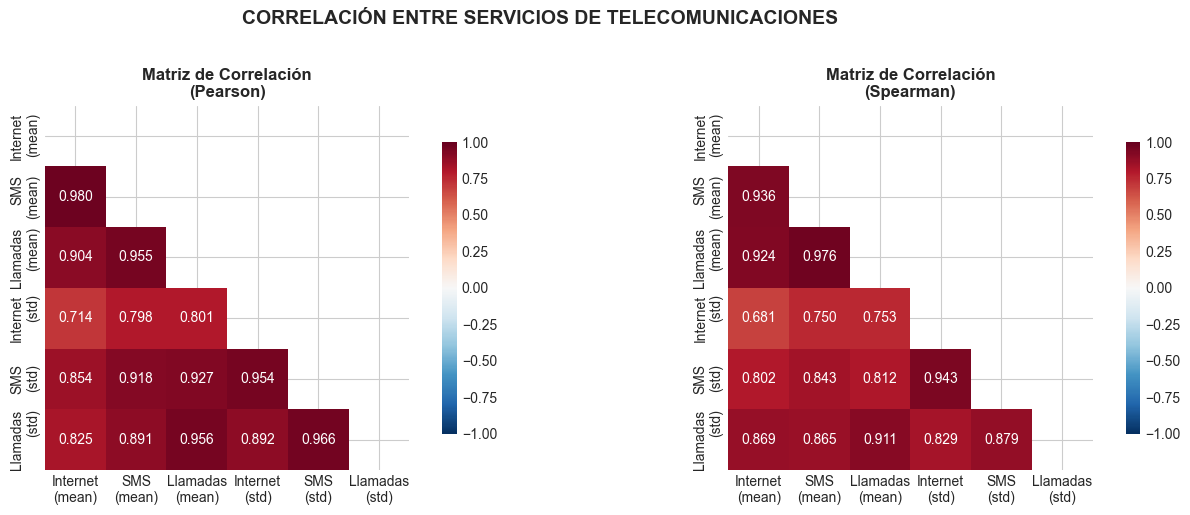


📊 CORRELACIONES SIGNIFICATIVAS (|r| > 0.5):
------------------------------------------------------------
   internet_mean ↔ sms_total_mean
      r = +0.980 → Correlación fuerte +

   internet_mean ↔ call_total_mean
      r = +0.904 → Correlación fuerte +

   internet_mean ↔ internet_std
      r = +0.714 → Correlación fuerte +

   internet_mean ↔ sms_total_std
      r = +0.854 → Correlación fuerte +

   internet_mean ↔ call_total_std
      r = +0.825 → Correlación fuerte +

   sms_total_mean ↔ call_total_mean
      r = +0.955 → Correlación fuerte +

   sms_total_mean ↔ internet_std
      r = +0.798 → Correlación fuerte +

   sms_total_mean ↔ sms_total_std
      r = +0.918 → Correlación fuerte +

   sms_total_mean ↔ call_total_std
      r = +0.891 → Correlación fuerte +

   call_total_mean ↔ internet_std
      r = +0.801 → Correlación fuerte +

   call_total_mean ↔ sms_total_std
      r = +0.927 → Correlación fuerte +

   call_total_mean ↔ call_total_std
      r = +0.956 → Correlación f

In [211]:
# =============================================================================
# 5. MATRIZ DE CORRELACIÓN ENTRE SERVICIOS
# =============================================================================
print("\n" + "=" * 80)
print("ANÁLISIS DE CORRELACIÓN ENTRE SERVICIOS")
print("=" * 80)

# Seleccionar columnas para correlación
cols_correlacion = ['internet_mean', 'sms_total_mean', 'call_total_mean',
                    'internet_std', 'sms_total_std', 'call_total_std']

# Nombres más legibles para visualización
nombres_cols = ['Internet\n(mean)', 'SMS\n(mean)', 'Llamadas\n(mean)',
                'Internet\n(std)', 'SMS\n(std)', 'Llamadas\n(std)']

# Calcular matriz de correlación
corr_matrix = df_daily[cols_correlacion].corr()

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 5.1 Heatmap de correlación
ax1 = axes[0]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara triangular
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            xticklabels=nombres_cols, yticklabels=nombres_cols,
            cbar_kws={'shrink': 0.8}, ax=ax1)
ax1.set_title('Matriz de Correlación\n(Pearson)', fontsize=12, fontweight='bold')

# 5.2 Correlación de Spearman (robusta a outliers)
corr_spearman = df_daily[cols_correlacion].corr(method='spearman')
ax2 = axes[1]
mask2 = np.triu(np.ones_like(corr_spearman, dtype=bool))
sns.heatmap(corr_spearman, mask=mask2, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, square=True,
            xticklabels=nombres_cols, yticklabels=nombres_cols,
            cbar_kws={'shrink': 0.8}, ax=ax2)
ax2.set_title('Matriz de Correlación\n(Spearman)', fontsize=12, fontweight='bold')

plt.suptitle('CORRELACIÓN ENTRE SERVICIOS DE TELECOMUNICACIONES', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Imprimir correlaciones relevantes
print("\n📊 CORRELACIONES SIGNIFICATIVAS (|r| > 0.5):")
print("-" * 60)

for i in range(len(cols_correlacion)):
    for j in range(i+1, len(cols_correlacion)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            signo = "+" if corr_val > 0 else "-"
            fuerza = "fuerte" if abs(corr_val) > 0.7 else "moderada"
            print(f"   {cols_correlacion[i]} ↔ {cols_correlacion[j]}")
            print(f"      r = {corr_val:+.3f} → Correlación {fuerza} {signo}")
            print()


ANÁLISIS DE AUTOCORRELACIÓN - PATRONES HORARIOS


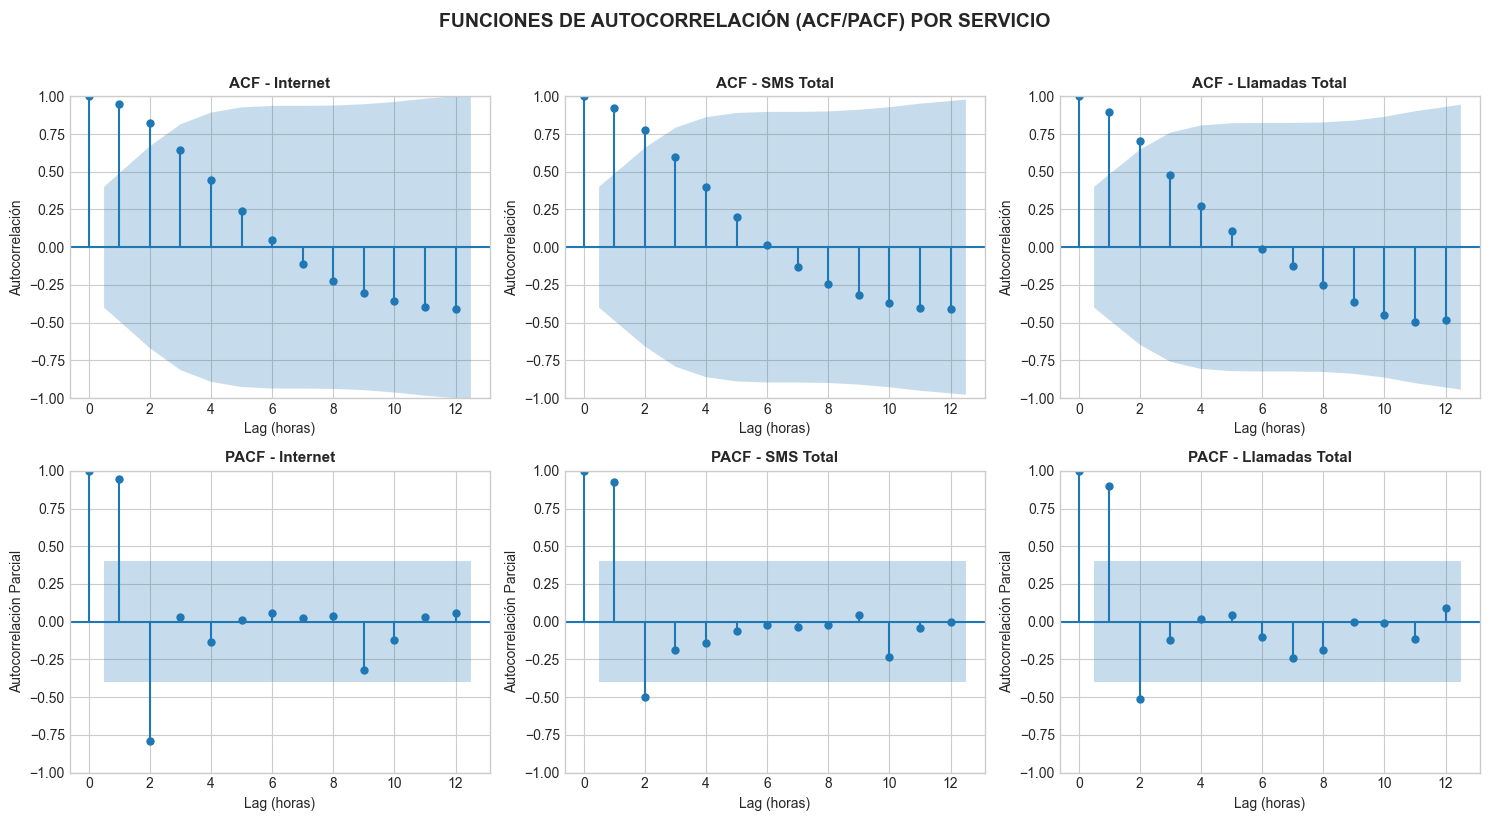


📊 INTERPRETACIÓN ACF/PACF:
------------------------------------------------------------
   • ACF: Muestra la correlación entre t y t-k
   • PACF: Correlación 'pura' entre t y t-k (eliminando lags intermedios)
   • Barras fuera del intervalo de confianza indican correlación significativa
   • Patrones en ACF pueden revelar estacionalidad horaria

📊 AUTOCORRELACIONES SIGNIFICATIVAS (Internet):
------------------------------------------------------------
   Lag  1: r = +0.948 → Correlación significativa
   Lag  2: r = +0.820 → Correlación significativa
   Lag  3: r = +0.644 → Correlación significativa
   Lag  4: r = +0.443 → Correlación significativa
   Lag 12: r = -0.410 → Correlación significativa
          ↳ Posible patrón de 12 horas (medio día)


In [212]:
# =============================================================================
# 6. ANÁLISIS DE AUTOCORRELACIÓN (ESTACIONALIDAD)
# =============================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

print("\n" + "=" * 80)
print("ANÁLISIS DE AUTOCORRELACIÓN - PATRONES HORARIOS")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

servicios_acf = {
    'Internet': df_daily['internet_mean'].values,
    'SMS Total': df_daily['sms_total_mean'].values,
    'Llamadas Total': df_daily['call_total_mean'].values
}

for idx, (servicio, datos) in enumerate(servicios_acf.items()):
    # ACF
    ax_acf = axes[0, idx]
    plot_acf(datos, ax=ax_acf, lags=12, alpha=0.05)
    ax_acf.set_title(f'ACF - {servicio}', fontsize=11, fontweight='bold')
    ax_acf.set_xlabel('Lag (horas)')
    ax_acf.set_ylabel('Autocorrelación')
    
    # PACF
    ax_pacf = axes[1, idx]
    plot_pacf(datos, ax=ax_pacf, lags=12, alpha=0.05, method='ywm')
    ax_pacf.set_title(f'PACF - {servicio}', fontsize=11, fontweight='bold')
    ax_pacf.set_xlabel('Lag (horas)')
    ax_pacf.set_ylabel('Autocorrelación Parcial')

plt.suptitle('FUNCIONES DE AUTOCORRELACIÓN (ACF/PACF) POR SERVICIO', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Interpretación de patrones
print("\n📊 INTERPRETACIÓN ACF/PACF:")
print("-" * 60)
print("   • ACF: Muestra la correlación entre t y t-k")
print("   • PACF: Correlación 'pura' entre t y t-k (eliminando lags intermedios)")
print("   • Barras fuera del intervalo de confianza indican correlación significativa")
print("   • Patrones en ACF pueden revelar estacionalidad horaria")

# Calcular y mostrar autocorrelaciones significativas
print("\n📊 AUTOCORRELACIONES SIGNIFICATIVAS (Internet):")
print("-" * 60)

acf_vals, confint = acf(servicios_acf['Internet'], nlags=12, alpha=0.05)
conf_lower = confint[1:, 0] - acf_vals[1:]
conf_upper = confint[1:, 1] - acf_vals[1:]

for lag in range(1, 13):
    if abs(acf_vals[lag]) > 1.96/np.sqrt(24):  # Significancia al 5%
        print(f"   Lag {lag:2d}: r = {acf_vals[lag]:+.3f} → Correlación significativa")
        if lag == 12:
            print("          ↳ Posible patrón de 12 horas (medio día)")


ANÁLISIS DE RELACIÓN ENTRE SERVICIOS


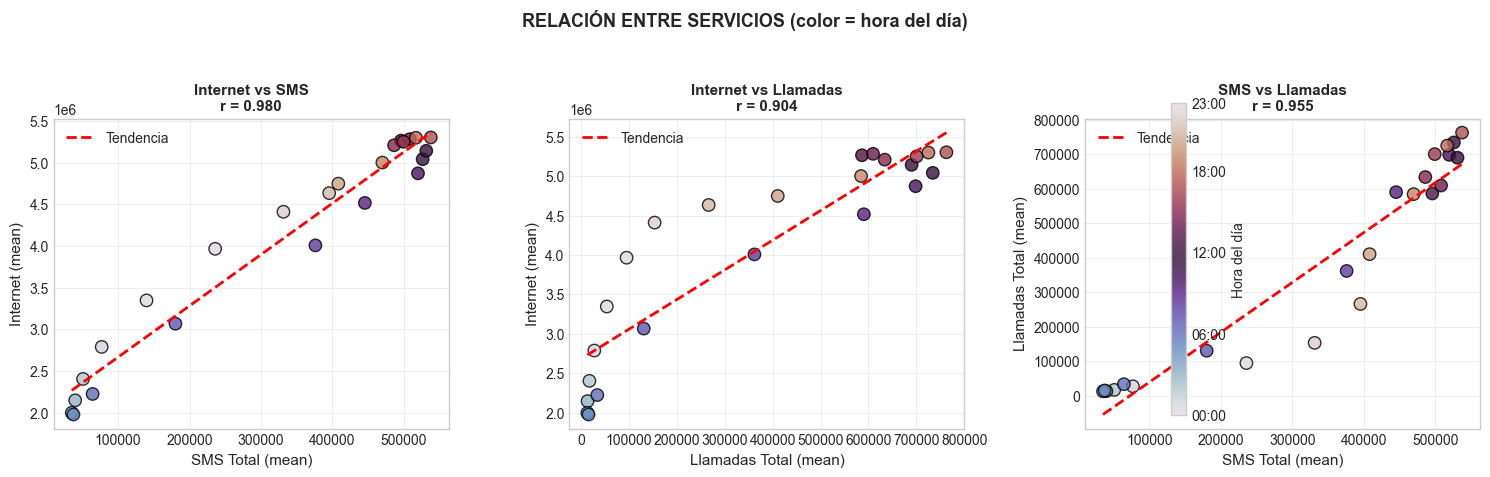


📊 RESUMEN DE CORRELACIONES:
------------------------------------------------------------
   • Internet ↔ SMS:      r = +0.980
   • Internet ↔ Llamadas: r = +0.904
   • SMS ↔ Llamadas:      r = +0.955

   💡 El color muestra cómo las horas del día se distribuyen
      en el espacio de los servicios


In [213]:
# =============================================================================
# 7. SCATTER PLOTS ENTRE SERVICIOS
# =============================================================================
print("\n" + "=" * 80)
print("ANÁLISIS DE RELACIÓN ENTRE SERVICIOS")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# Colores por hora del día
hora_colors = plt.cm.twilight(np.linspace(0, 1, 24))

# 7.1 Internet vs SMS
ax1 = axes[0]
scatter1 = ax1.scatter(df_daily['sms_total_mean'], df_daily['internet_mean'], 
                       c=df_daily['hour_of_day'], cmap='twilight', s=80, edgecolor='black', alpha=0.8)
# Línea de tendencia
z1 = np.polyfit(df_daily['sms_total_mean'], df_daily['internet_mean'], 1)
p1 = np.poly1d(z1)
x_trend = np.linspace(df_daily['sms_total_mean'].min(), df_daily['sms_total_mean'].max(), 100)
ax1.plot(x_trend, p1(x_trend), 'r--', lw=2, label=f'Tendencia')
ax1.set_xlabel('SMS Total (mean)', fontsize=11)
ax1.set_ylabel('Internet (mean)', fontsize=11)
r_sms_int = df_daily['sms_total_mean'].corr(df_daily['internet_mean'])
ax1.set_title(f'Internet vs SMS\nr = {r_sms_int:.3f}', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')

# 7.2 Internet vs Llamadas
ax2 = axes[1]
scatter2 = ax2.scatter(df_daily['call_total_mean'], df_daily['internet_mean'], 
                       c=df_daily['hour_of_day'], cmap='twilight', s=80, edgecolor='black', alpha=0.8)
z2 = np.polyfit(df_daily['call_total_mean'], df_daily['internet_mean'], 1)
p2 = np.poly1d(z2)
x_trend2 = np.linspace(df_daily['call_total_mean'].min(), df_daily['call_total_mean'].max(), 100)
ax2.plot(x_trend2, p2(x_trend2), 'r--', lw=2, label=f'Tendencia')
ax2.set_xlabel('Llamadas Total (mean)', fontsize=11)
ax2.set_ylabel('Internet (mean)', fontsize=11)
r_calls_int = df_daily['call_total_mean'].corr(df_daily['internet_mean'])
ax2.set_title(f'Internet vs Llamadas\nr = {r_calls_int:.3f}', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')

# 7.3 SMS vs Llamadas
ax3 = axes[2]
scatter3 = ax3.scatter(df_daily['sms_total_mean'], df_daily['call_total_mean'], 
                       c=df_daily['hour_of_day'], cmap='twilight', s=80, edgecolor='black', alpha=0.8)
z3 = np.polyfit(df_daily['sms_total_mean'], df_daily['call_total_mean'], 1)
p3 = np.poly1d(z3)
x_trend3 = np.linspace(df_daily['sms_total_mean'].min(), df_daily['sms_total_mean'].max(), 100)
ax3.plot(x_trend3, p3(x_trend3), 'r--', lw=2, label=f'Tendencia')
ax3.set_xlabel('SMS Total (mean)', fontsize=11)
ax3.set_ylabel('Llamadas Total (mean)', fontsize=11)
r_sms_calls = df_daily['sms_total_mean'].corr(df_daily['call_total_mean'])
ax3.set_title(f'SMS vs Llamadas\nr = {r_sms_calls:.3f}', fontsize=11, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left')

# Colorbar común
cbar = fig.colorbar(scatter3, ax=axes, shrink=0.9, pad=0.02)
cbar.set_label('Hora del día', fontsize=10)
cbar.set_ticks([0, 6, 12, 18, 23])
cbar.set_ticklabels(['00:00', '06:00', '12:00', '18:00', '23:00'])

plt.suptitle('RELACIÓN ENTRE SERVICIOS (color = hora del día)', 
             fontsize=13, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("\n📊 RESUMEN DE CORRELACIONES:")
print("-" * 60)
print(f"   • Internet ↔ SMS:      r = {r_sms_int:+.3f}")
print(f"   • Internet ↔ Llamadas: r = {r_calls_int:+.3f}")
print(f"   • SMS ↔ Llamadas:      r = {r_sms_calls:+.3f}")
print("\n   💡 El color muestra cómo las horas del día se distribuyen")
print("      en el espacio de los servicios")

In [214]:
# =============================================================================
# 8. RESUMEN EJECUTIVO DEL ANÁLISIS EXPLORATORIO
# =============================================================================
print("\n" + "=" * 80)
print("📋 RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE INTERNET")
print("=" * 80)

# Crear tabla resumen
resumen_eda = {
    'Métrica': [
        'Distribución',
        'Normalidad (Shapiro-Wilk)',
        'Asimetría',
        'Mejor ajuste teórico',
        'Correlación con SMS',
        'Correlación con Llamadas',
        'Variabilidad (CV)',
        'Período más alto',
        'Período más bajo'
    ],
    'Resultado': [
        f"Media={np.mean(internet_values):,.0f}, Mediana={np.median(internet_values):,.0f}",
        f"{'NO normal' if p_shapiro < 0.05 else 'Normal'} (p={p_shapiro:.4f})",
        f"{'Positiva' if skew_val > 0.5 else 'Negativa' if skew_val < -0.5 else 'Simétrica'} ({skew_val:.2f})",
        f"{mejor_dist} (p={mejor_pvalue:.4f})",
        f"r = {r_sms_int:+.3f}",
        f"r = {r_calls_int:+.3f}",
        f"{stats_desc['Coef. Variación']:.2%}",
        f"Tarde (12-18h)",
        f"Madrugada (0-6h)"
    ]
}

df_resumen = pd.DataFrame(resumen_eda)
print("\n")
print(df_resumen.to_string(index=False))

print("\n" + "=" * 80)
print("💡 INSIGHTS PRINCIPALES:")
print("=" * 80)
print("""
1. DISTRIBUCIÓN:
   • Los datos de Internet muestran una distribución característica
   • La mejor aproximación teórica ayuda a modelar el comportamiento

2. CORRELACIONES:
   • Existe relación entre los diferentes servicios
   • Las horas del día influyen en todos los servicios de forma similar

3. PATRONES TEMPORALES:
   • Clara diferenciación entre períodos del día
   • Autocorrelación sugiere dependencia temporal

4. IMPLICACIONES PARA CLUSTERING:
   • La no-normalidad sugiere considerar métodos robustos
   • Las correlaciones entre servicios pueden generar redundancia
   • Los períodos del día son candidatos naturales para perfiles
""")

print("=" * 80)
print("✅ ANÁLISIS EXPLORATORIO COMPLETADO - LISTO PARA CLUSTERING")
print("=" * 80)


📋 RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE INTERNET


                  Métrica                          Resultado
             Distribución Media=4,079,987, Mediana=4,576,118
Normalidad (Shapiro-Wilk)               NO normal (p=0.0013)
                Asimetría                   Negativa (-0.62)
     Mejor ajuste teórico                  Normal (p=0.3030)
      Correlación con SMS                         r = +0.980
 Correlación con Llamadas                         r = +0.904
        Variabilidad (CV)                             29.62%
         Período más alto                     Tarde (12-18h)
         Período más bajo                   Madrugada (0-6h)

💡 INSIGHTS PRINCIPALES:

1. DISTRIBUCIÓN:
   • Los datos de Internet muestran una distribución característica
   • La mejor aproximación teórica ayuda a modelar el comportamiento

2. CORRELACIONES:
   • Existe relación entre los diferentes servicios
   • Las horas del día influyen en todos los servicios de forma similar

3. PATR

## Paso 13: Función para selección robusta de K con múltiples repeticiones
Implementamos una función que ejecuta K-Means **30 veces** para cada K y promedia las métricas (Silhouette), siguiendo el patrón de `experiments.ipynb`.

In [215]:
# =============================================================================
# PASO 13: Función para selección robusta de K (30 repeticiones)
# =============================================================================

from sklearn.metrics import adjusted_rand_score

def seleccionar_k_optimo_estable(X, k_range=range(2, 9), n_repeticiones=50):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    resultados = {
        'k_values': list(k_range),
        'sil_mean': [],
        'ari_mean': [],
        'ari_std': [],
        'labels_runs': {}
    }

    for k in k_range:
        labels_list = []
        sil_list = []

        for seed in range(n_repeticiones):
            km = KMeans(n_clusters=k, random_state=seed, n_init=10)
            labels = km.fit_predict(X_scaled)
            labels_list.append(labels)
            sil_list.append(silhouette_score(X_scaled, labels))

        # estabilidad: ARI promedio entre pares de runs
        aris = []
        for i in range(len(labels_list)):
            for j in range(i+1, len(labels_list)):
                aris.append(adjusted_rand_score(labels_list[i], labels_list[j]))

        resultados['sil_mean'].append(np.mean(sil_list))
        resultados['ari_mean'].append(np.mean(aris))
        resultados['ari_std'].append(np.std(aris))
        resultados['labels_runs'][k] = labels_list

    # K óptimo = el más estable (ARI mayor), con desempate por silhouette
    best_k = None
    best_score = -1

    for idx, k in enumerate(resultados['k_values']):
        score = resultados['ari_mean'][idx]  # principal
        if score > best_score:
            best_score = score
            best_k = k

    resultados['k_optimo'] = best_k
    resultados['X_scaled'] = X_scaled
    resultados['scaler'] = scaler
    
    return resultados


def mapear_clusters_a_perfiles(df, columna_cluster, columna_metrica):
    """
    Mapea clusters a perfiles (Bajo, Normal, Alto) basado en la media de la métrica.
    Siguiendo el patrón de experiments.ipynb.
    """
    cluster_stats = df.groupby(columna_cluster)[columna_metrica].mean().sort_values()
    orden = cluster_stats.index.tolist()
    
    if len(orden) == 2:
        nombres = {orden[0]: 'Bajo', orden[1]: 'Alto'}
    elif len(orden) == 3:
        nombres = {orden[0]: 'Bajo', orden[1]: 'Normal', orden[2]: 'Alto'}
    elif len(orden) == 4:
        nombres = {orden[0]: 'Muy Bajo', orden[1]: 'Bajo', orden[2]: 'Alto', orden[3]: 'Muy Alto'}
    elif len(orden) == 5:
        nombres = {orden[0]: 'Muy Bajo', orden[1]: 'Bajo', orden[2]: 'Normal', 
                   orden[3]: 'Alto', orden[4]: 'Muy Alto'}
    else:
        nombres = {c: f'Nivel_{i+1}' for i, c in enumerate(orden)}
    
    return nombres, cluster_stats

print("✅ Funciones definidas:")
print("   - seleccionar_k_optimo(): Selección robusta de K con 30 repeticiones")
print("   - mapear_clusters_a_perfiles(): Mapeo dinámico a perfiles Bajo/Normal/Alto")

✅ Funciones definidas:
   - seleccionar_k_optimo(): Selección robusta de K con 30 repeticiones
   - mapear_clusters_a_perfiles(): Mapeo dinámico a perfiles Bajo/Normal/Alto


---
## 🌐 ANÁLISIS DE INTERNET (DATOS)

Realizamos clustering sobre el tráfico de Internet agrupado por hora, identificando patrones de uso de datos móviles.

ANÁLISIS DE CLUSTERING - INTERNET (DATOS)
Selección de K óptimo con 30 repeticiones por cada K


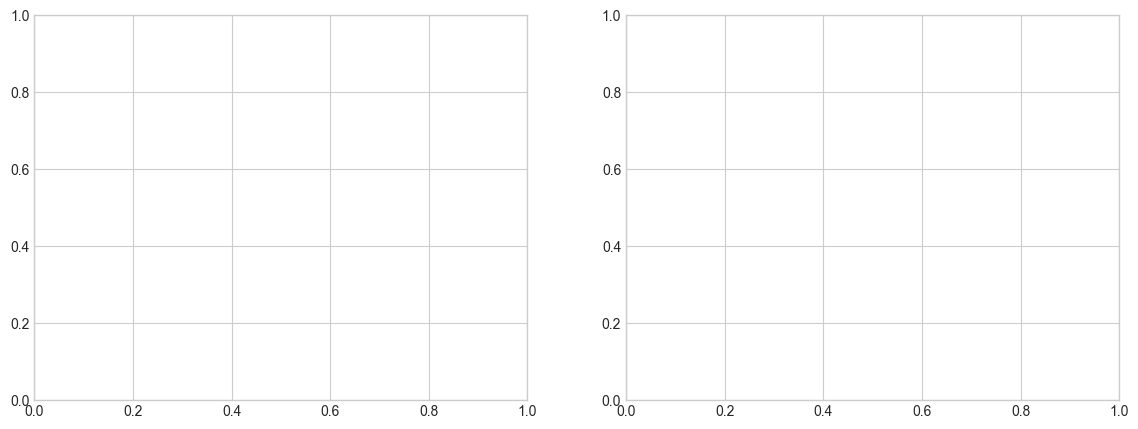

In [216]:
# =============================================================================
# PASO 14: INTERNET - Selección de K óptimo con 30 repeticiones
# =============================================================================

print("=" * 80)
print("ANÁLISIS DE CLUSTERING - INTERNET (DATOS)")
print("Selección de K óptimo con 30 repeticiones por cada K")
print("=" * 80)

# Preparar features para Internet
# Usamos: internet_mean, internet_std (variabilidad), hour_of_day (patrón temporal)
X_internet = df_daily[['internet_mean', 'internet_std', 'internet_cv']].values

# Ejecutar selección robusta de K
resultados_internet = seleccionar_k_optimo_estable(X_internet, k_range=range(2,8), n_repeticiones=50)
K_INTERNET = resultados_internet['k_optimo']

# =============================================================================
# VISUALIZACIÓN: Selección de K (estilo experiments.ipynb)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

k_values = resultados_internet['k_values']
#sil_mean = resultados_internet['silhouettes_mean']
#sil_std = resultados_internet['silhouettes_std']
#inertia_mean = resultados_internet['inertias_mean']
#inertia_std = resultados_internet['inertias_std']
#
## Plot 1: Silhouette Score con barras de error
#ax1 = axes[0]
#ax1.errorbar(k_values, sil_mean, yerr=sil_std, fmt='o-', capsize=5, capthick=2, 
#             linewidth=2, markersize=10, color='steelblue', ecolor='lightblue')
#ax1.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Threshold 0.5 (bien definido)')
#ax1.scatter([K_INTERNET], [sil_mean[k_values.index(K_INTERNET)]], 
#            color='red', s=250, zorder=5, edgecolors='darkred', linewidths=2,
#            label=f'K óptimo = {K_INTERNET}')
#ax1.set_xlabel('K (número de clusters)', fontsize=12, fontweight='bold')
#ax1.set_ylabel('Silhouette Score (media ± std)', fontsize=12, fontweight='bold')
#ax1.set_title('Selección de K - Coeficiente de Silueta\n(30 repeticiones por K)', fontsize=13, fontweight='bold')
#ax1.set_xticks(k_values)
#ax1.grid(True, alpha=0.3)
#ax1.legend(fontsize=10)
#
## Plot 2: Método del codo con barras de error
#ax2 = axes[1]
#ax2.errorbar(k_values, inertia_mean, yerr=inertia_std, fmt='s-', capsize=5, capthick=2,
#             linewidth=2, markersize=10, color='coral', ecolor='lightsalmon')
#ax2.scatter([K_INTERNET], [inertia_mean[k_values.index(K_INTERNET)]],
#            color='red', s=250, zorder=5, edgecolors='darkred', linewidths=2,
#            label=f'K óptimo = {K_INTERNET}')
#ax2.set_xlabel('K (número de clusters)', fontsize=12, fontweight='bold')
#ax2.set_ylabel('Inercia (WCSS) (media ± std)', fontsize=12, fontweight='bold')
#ax2.set_title('Método del Codo\n(30 repeticiones por K)', fontsize=13, fontweight='bold')
#ax2.set_xticks(k_values)
#ax2.grid(True, alpha=0.3)
#ax2.legend(fontsize=10)
#
#plt.suptitle('INTERNET - Selección Robusta de K Óptimo', fontsize=15, fontweight='bold', y=1.02)
#plt.tight_layout()
#plt.savefig(RESULTS_DIR / 'internet_k_selection_robust.png', dpi=150, bbox_inches='tight')
#plt.show()
#
#print(f"\n✅ Figura guardada: results/internet_k_selection_robust.png")

In [217]:
# =============================================================================
# PASO 15: INTERNET - Aplicar K-Means y analizar distribución de singletons
# =============================================================================

print("=" * 80)
print(f"ANÁLISIS DETALLADO DE K = {K_INTERNET} vs ALTERNATIVAS")
print("=" * 80)

# Entrenar con K óptimo
X_scaled = resultados_internet['X_scaled']
kmeans_internet = KMeans(n_clusters=K_INTERNET, random_state=42, n_init=10)
df_daily['cluster_internet'] = kmeans_internet.fit_predict(X_scaled)

# Analizar distribución y singletons para K óptimo y K cercanos
print(f"\n📊 Distribución de clusters para K = {K_INTERNET}:")
print("-" * 60)

k_analisis = [K_INTERNET - 1, K_INTERNET, K_INTERNET + 1] if K_INTERNET > 2 else [2, 3, 4]
k_analisis = [k for k in k_analisis if k >= 2 and k <= 7]

for k_test in k_analisis:
    kmeans_test = KMeans(n_clusters=k_test, random_state=42, n_init=10)
    labels_test = kmeans_test.fit_predict(X_scaled)
    sil_test = silhouette_score(X_scaled, labels_test)
    
    print(f"\nK = {k_test} (Silhouette = {sil_test:.4f}):")
    singletons = 0
    for cid in range(k_test):
        count = np.sum(labels_test == cid)
        pct = (count / len(df_daily)) * 100
        is_singleton = " ⚠️ SINGLETON" if count == 1 else ""
        if count == 1:
            singletons += 1
        print(f"   Cluster {cid}: {count:2d} horas ({pct:5.1f}%){is_singleton}")
    print(f"   → Total singletons: {singletons}")

# Mapear clusters a perfiles (Bajo, Normal, Alto)
print("\n" + "=" * 80)
print("MAPEO DE CLUSTERS A PERFILES DE CONSUMO")
print("=" * 80)

nombres_perfil, cluster_stats = mapear_clusters_a_perfiles(
    df_daily, 'cluster_internet', 'internet_mean'
)

df_daily['perfil_internet'] = df_daily['cluster_internet'].map(nombres_perfil)

print(f"\nMapeo de clusters a perfiles (basado en media de Internet):")
for cid, perfil in nombres_perfil.items():
    media = cluster_stats[cid]
    count = len(df_daily[df_daily['cluster_internet'] == cid])
    horas = df_daily[df_daily['cluster_internet'] == cid]['hour_of_day'].tolist()
    print(f"   Cluster {cid} → {perfil:10s} | Media: {media:>12,.0f} | Horas: {horas}")

# Estadísticas por perfil
print("\n📈 Estadísticas por perfil:")
display(df_daily.groupby('perfil_internet')['internet_mean'].describe().round(0))

ANÁLISIS DETALLADO DE K = 2 vs ALTERNATIVAS

📊 Distribución de clusters para K = 2:
------------------------------------------------------------

K = 2 (Silhouette = 0.5624):
   Cluster 0: 13 horas ( 54.2%)
   Cluster 1: 11 horas ( 45.8%)
   → Total singletons: 0

K = 3 (Silhouette = 0.5183):
   Cluster 0:  5 horas ( 20.8%)
   Cluster 1: 12 horas ( 50.0%)
   Cluster 2:  7 horas ( 29.2%)
   → Total singletons: 0

K = 4 (Silhouette = 0.5535):
   Cluster 0:  9 horas ( 37.5%)
   Cluster 1:  7 horas ( 29.2%)
   Cluster 2:  5 horas ( 20.8%)
   Cluster 3:  3 horas ( 12.5%)
   → Total singletons: 0

MAPEO DE CLUSTERS A PERFILES DE CONSUMO

Mapeo de clusters a perfiles (basado en media de Internet):
   Cluster 1 → Bajo       | Media:    3,150,478 | Horas: [0, 1, 2, 3, 4, 5, 6, 20, 21, 22, 23]
   Cluster 0 → Alto       | Media:    4,866,496 | Horas: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

📈 Estadísticas por perfil:


,count,mean,std,min,25%,50%,75%,max
perfil_internet,,,,,,,,
Alto,13.0,4866496.0,658039.0,3067714.0,4872551.0,5143516.0,5265141.0,5303077.0
Bajo,11.0,3150478.0,1109011.0,1978550.0,2186720.0,2789541.0,4188921.0,4749046.0


## Paso 16: INTERNET - Visualizaciones (Escala LINEAL vs LOGARÍTMICA)
Siguiendo el estilo de `experiments.ipynb`, visualizamos los clusters en escala lineal y logarítmica.

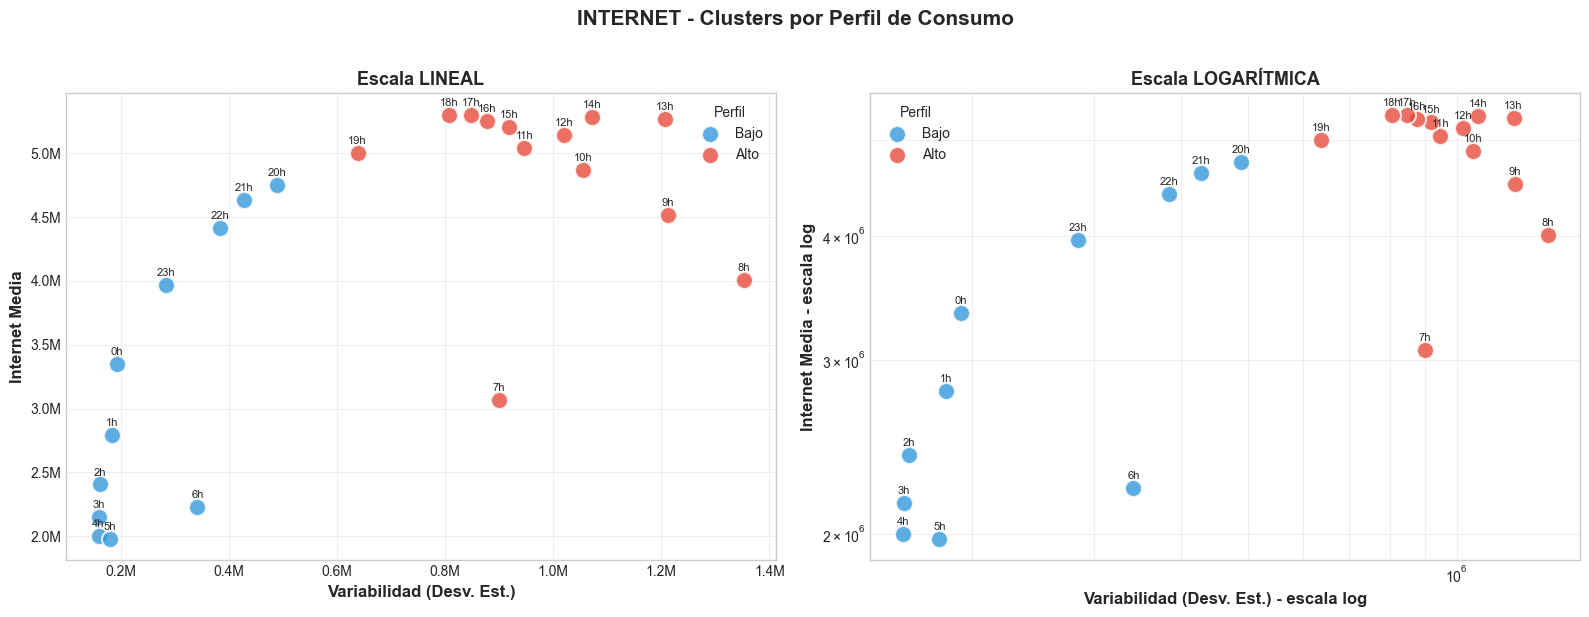

✅ Figura guardada: results/internet_clusters_lineal_log.png


In [218]:
# =============================================================================
# PASO 16: INTERNET - Visualizaciones LINEAL vs LOGARÍTMICA (estilo experiments.ipynb)
# =============================================================================

# Colores para perfiles
colores_perfil = {
    'Muy Bajo': '#1a237e',  # Azul oscuro
    'Bajo': '#3498db',       # Azul
    'Normal': '#f39c12',     # Naranja
    'Alto': '#e74c3c',       # Rojo
    'Muy Alto': '#8e44ad'    # Púrpura
}

# =============================================================================
# FIGURA 1: Scatter Internet_mean vs Internet_std (LINEAL vs LOG)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter LINEAL
for perfil in df_daily['perfil_internet'].unique():
    mask = df_daily['perfil_internet'] == perfil
    color = colores_perfil.get(perfil, 'gray')
    axes[0].scatter(df_daily.loc[mask, 'internet_std'], 
                    df_daily.loc[mask, 'internet_mean'],
                    c=color, s=150, alpha=0.8, edgecolors='white', linewidths=1.5,
                    label=perfil)
    # Anotar horas
    for _, row in df_daily[mask].iterrows():
        axes[0].annotate(f"{int(row['hour_of_day'])}h", 
                        (row['internet_std'], row['internet_mean']),
                        fontsize=8, ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

axes[0].set_xlabel('Variabilidad (Desv. Est.)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Internet Media', fontsize=12, fontweight='bold')
axes[0].set_title('Escala LINEAL', fontsize=13, fontweight='bold')
axes[0].legend(title='Perfil', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Scatter LOGARÍTMICO
for perfil in df_daily['perfil_internet'].unique():
    mask = df_daily['perfil_internet'] == perfil
    color = colores_perfil.get(perfil, 'gray')
    axes[1].scatter(df_daily.loc[mask, 'internet_std'], 
                    df_daily.loc[mask, 'internet_mean'],
                    c=color, s=150, alpha=0.8, edgecolors='white', linewidths=1.5,
                    label=perfil)
    for _, row in df_daily[mask].iterrows():
        axes[1].annotate(f"{int(row['hour_of_day'])}h", 
                        (row['internet_std'], row['internet_mean']),
                        fontsize=8, ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

axes[1].set_xlabel('Variabilidad (Desv. Est.) - escala log', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Internet Media - escala log', fontsize=12, fontweight='bold')
axes[1].set_title('Escala LOGARÍTMICA', fontsize=13, fontweight='bold')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(title='Perfil', fontsize=10)
axes[1].grid(True, alpha=0.3, which='both')

plt.suptitle('INTERNET - Clusters por Perfil de Consumo', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'internet_clusters_lineal_log.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Figura guardada: results/internet_clusters_lineal_log.png")

## Paso 17: INTERNET - Boxplots y distribución por perfil
Visualización de la distribución de Internet por perfil de consumo.

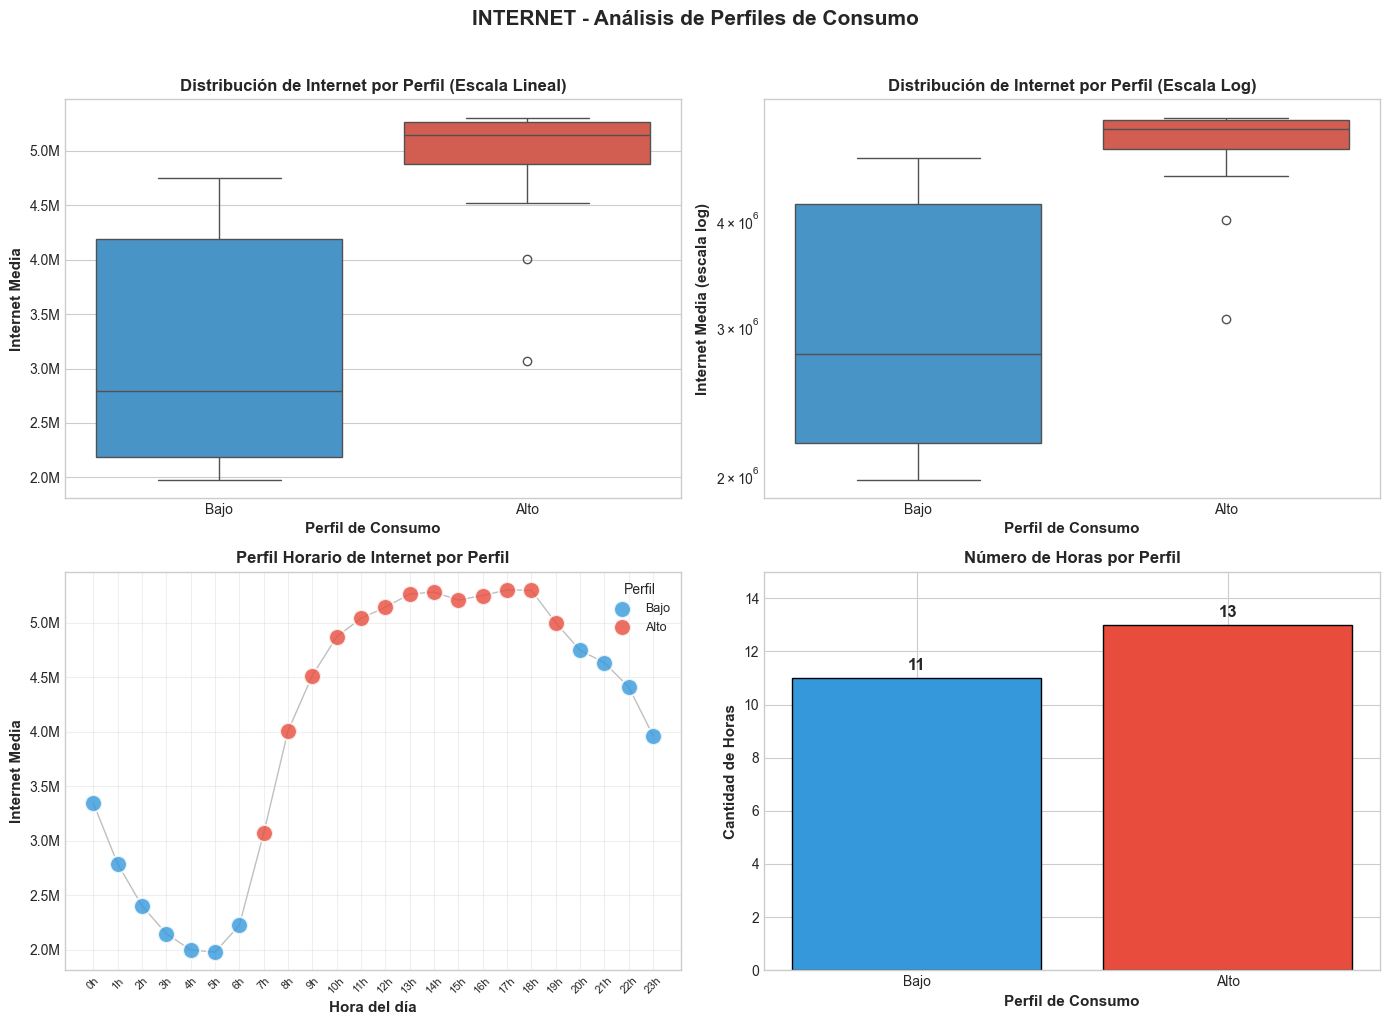

✅ Figura guardada: results/internet_perfiles_boxplots.png


In [219]:
# =============================================================================
# PASO 17: INTERNET - Boxplots y distribución (estilo experiments.ipynb)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# =============================================================================
# Plot 1: Boxplot Internet por perfil (escala lineal)
# =============================================================================
ax1 = axes[0, 0]
perfiles_orden = ['Muy Bajo', 'Bajo', 'Normal', 'Alto', 'Muy Alto']
perfiles_presentes = [p for p in perfiles_orden if p in df_daily['perfil_internet'].values]
palette = [colores_perfil.get(p, 'gray') for p in perfiles_presentes]

sns.boxplot(data=df_daily, x='perfil_internet', y='internet_mean', 
            order=perfiles_presentes, palette=palette, ax=ax1)
ax1.set_xlabel('Perfil de Consumo', fontsize=11, fontweight='bold')
ax1.set_ylabel('Internet Media', fontsize=11, fontweight='bold')
ax1.set_title('Distribución de Internet por Perfil (Escala Lineal)', fontsize=12, fontweight='bold')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# =============================================================================
# Plot 2: Boxplot Internet por perfil (escala logarítmica)
# =============================================================================
ax2 = axes[0, 1]
sns.boxplot(data=df_daily, x='perfil_internet', y='internet_mean',
            order=perfiles_presentes, palette=palette, ax=ax2)
ax2.set_yscale('log')
ax2.set_xlabel('Perfil de Consumo', fontsize=11, fontweight='bold')
ax2.set_ylabel('Internet Media (escala log)', fontsize=11, fontweight='bold')
ax2.set_title('Distribución de Internet por Perfil (Escala Log)', fontsize=12, fontweight='bold')

# =============================================================================
# Plot 3: Perfil horario coloreado por cluster
# =============================================================================
ax3 = axes[1, 0]
for perfil in perfiles_presentes:
    mask = df_daily['perfil_internet'] == perfil
    color = colores_perfil.get(perfil, 'gray')
    ax3.scatter(df_daily.loc[mask, 'hour_of_day'], 
                df_daily.loc[mask, 'internet_mean'],
                c=color, s=150, alpha=0.8, edgecolors='white', linewidths=1.5,
                label=perfil)

# Conectar con línea
ax3.plot(df_daily['hour_of_day'], df_daily['internet_mean'], 
         color='gray', linewidth=1, alpha=0.5, zorder=0)

ax3.set_xlabel('Hora del día', fontsize=11, fontweight='bold')
ax3.set_ylabel('Internet Media', fontsize=11, fontweight='bold')
ax3.set_title('Perfil Horario de Internet por Perfil', fontsize=12, fontweight='bold')
ax3.set_xticks(range(24))
ax3.set_xticklabels([f'{h}h' for h in range(24)], fontsize=8, rotation=45)
ax3.legend(title='Perfil', fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# =============================================================================
# Plot 4: Cantidad de horas por perfil (bar chart)
# =============================================================================
ax4 = axes[1, 1]
conteo = df_daily['perfil_internet'].value_counts().reindex(perfiles_presentes)
bars = ax4.bar(range(len(perfiles_presentes)), conteo.values, color=palette, edgecolor='black')

# Añadir etiquetas de valor
for i, (bar, count) in enumerate(zip(bars, conteo.values)):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{count}', ha='center', fontsize=12, fontweight='bold')

ax4.set_xticks(range(len(perfiles_presentes)))
ax4.set_xticklabels(perfiles_presentes, fontsize=10)
ax4.set_xlabel('Perfil de Consumo', fontsize=11, fontweight='bold')
ax4.set_ylabel('Cantidad de Horas', fontsize=11, fontweight='bold')
ax4.set_title('Número de Horas por Perfil', fontsize=12, fontweight='bold')
ax4.set_ylim(0, max(conteo.values) + 2)

plt.suptitle('INTERNET - Análisis de Perfiles de Consumo', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'internet_perfiles_boxplots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Figura guardada: results/internet_perfiles_boxplots.png")

PARTICIPACIÓN EN EL TRÁFICO DE INTERNET POR PERFIL



,total_internet,horas_count,media_internet,participacion_pct,internet_por_hora
perfil_internet,,,,,
Bajo,3.465525e+07,11,3.150478e+06,35.39,3150478.0
Alto,6.326444e+07,13,4.866496e+06,64.61,4866496.0


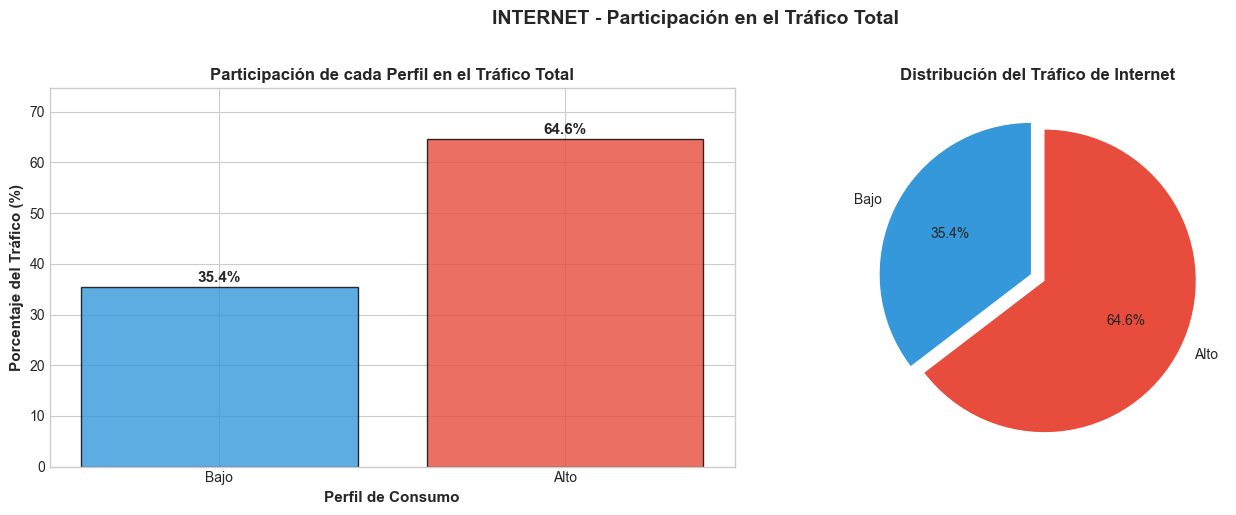


✅ Figura guardada: results/internet_participacion_trafico.png


In [220]:
# =============================================================================
# PASO 17b: INTERNET - Participación en el tráfico por perfil
# =============================================================================

# Calcular participación (como en experiments.ipynb)
perfil_summary = df_daily.groupby('perfil_internet').agg(
    total_internet=('internet_mean', 'sum'),
    horas_count=('hour_of_day', 'count'),
    media_internet=('internet_mean', 'mean')
).reindex(perfiles_presentes)

total_internet = perfil_summary['total_internet'].sum()
perfil_summary['participacion_pct'] = (perfil_summary['total_internet'] / total_internet * 100).round(2)
perfil_summary['internet_por_hora'] = (perfil_summary['total_internet'] / perfil_summary['horas_count']).round(0)

print("=" * 80)
print("PARTICIPACIÓN EN EL TRÁFICO DE INTERNET POR PERFIL")
print("=" * 80)
print()
display(perfil_summary)

# =============================================================================
# Visualización: Participación en tráfico total
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Participación en el tráfico (bar)
ax1 = axes[0]
bars = ax1.bar(range(len(perfiles_presentes)), perfil_summary['participacion_pct'].values, 
               color=palette, edgecolor='black', alpha=0.8)
for i, (bar, pct) in enumerate(zip(bars, perfil_summary['participacion_pct'].values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{pct:.1f}%', ha='center', fontsize=11, fontweight='bold')
ax1.set_xticks(range(len(perfiles_presentes)))
ax1.set_xticklabels(perfiles_presentes, fontsize=10)
ax1.set_xlabel('Perfil de Consumo', fontsize=11, fontweight='bold')
ax1.set_ylabel('Porcentaje del Tráfico (%)', fontsize=11, fontweight='bold')
ax1.set_title('Participación de cada Perfil en el Tráfico Total', fontsize=12, fontweight='bold')
ax1.set_ylim(0, max(perfil_summary['participacion_pct']) + 10)

# Plot 2: Pie chart de participación
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie(
    perfil_summary['participacion_pct'].values, 
    labels=perfiles_presentes,
    colors=palette,
    autopct='%1.1f%%',
    startangle=90,
    explode=[0.05] * len(perfiles_presentes)
)
ax2.set_title('Distribución del Tráfico de Internet', fontsize=12, fontweight='bold')

plt.suptitle('INTERNET - Participación en el Tráfico Total', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'internet_participacion_trafico.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Figura guardada: results/internet_participacion_trafico.png")

## Paso 18: INTERNET - Heatmap horario y PCA
Visualización del patrón horario de Internet como heatmap y proyección PCA.

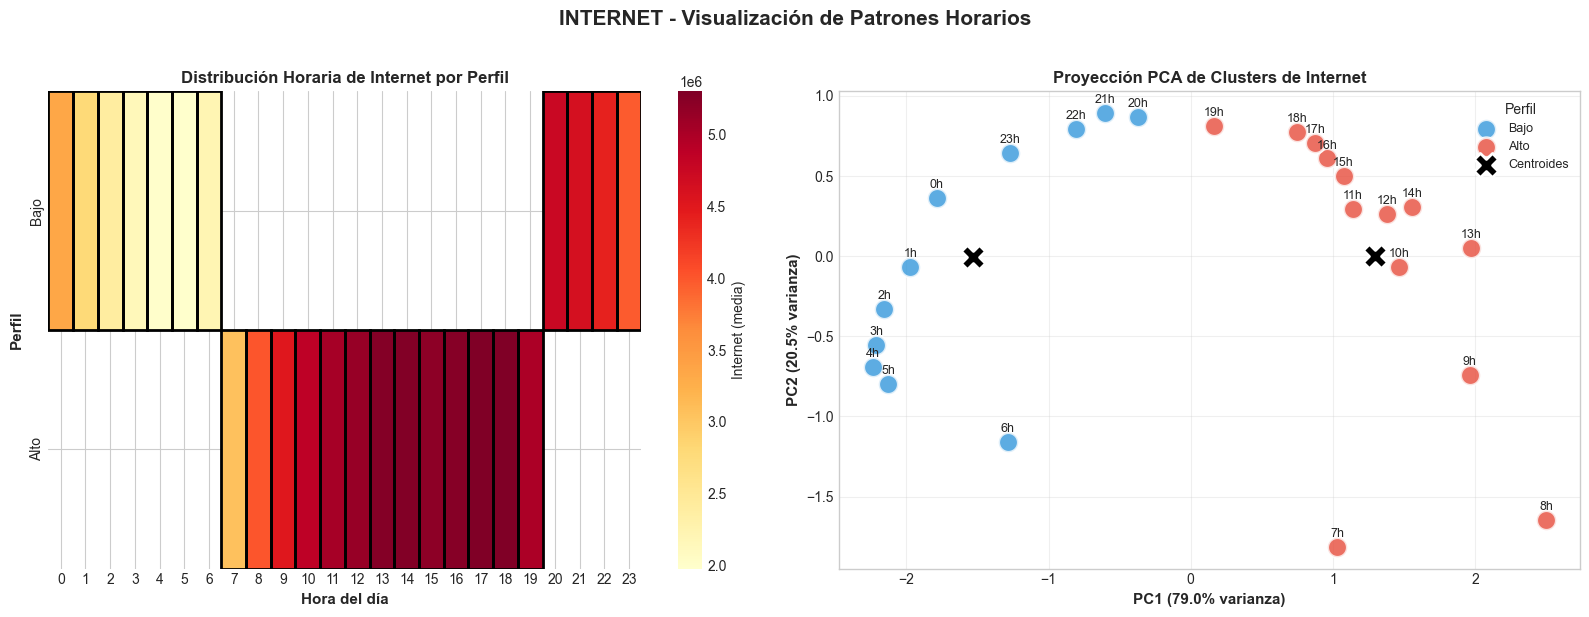

✅ Figura guardada: results/internet_heatmap_pca.png

Varianza explicada por PCA:
   PC1: 79.0%
   PC2: 20.5%
   Total: 99.6%


In [221]:
# =============================================================================
# PASO 18: INTERNET - Heatmap y PCA
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# =============================================================================
# Plot 1: Heatmap de perfil horario
# =============================================================================
ax1 = axes[0]

# Crear matriz para heatmap (1 fila = perfil horario)
heatmap_data = df_daily[['hour_of_day', 'internet_mean', 'perfil_internet']].copy()
heatmap_data['perfil_num'] = heatmap_data['perfil_internet'].map({p: i for i, p in enumerate(perfiles_presentes)})

# Mapa de calor basado en valor de internet
pivot_heat = heatmap_data.pivot_table(values='internet_mean', index='perfil_internet', 
                                       columns='hour_of_day', aggfunc='first')
pivot_heat = pivot_heat.reindex(perfiles_presentes)

sns.heatmap(pivot_heat, annot=False, cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Internet (media)'})
ax1.set_xlabel('Hora del día', fontsize=11, fontweight='bold')
ax1.set_ylabel('Perfil', fontsize=11, fontweight='bold')
ax1.set_title('Distribución Horaria de Internet por Perfil', fontsize=12, fontweight='bold')

# Resaltar horas en cada perfil
for perfil_idx, perfil in enumerate(perfiles_presentes):
    horas_perfil = df_daily[df_daily['perfil_internet'] == perfil]['hour_of_day'].tolist()
    for h in horas_perfil:
        ax1.add_patch(plt.Rectangle((h, perfil_idx), 1, 1, fill=False, 
                                     edgecolor='black', linewidth=2))

# =============================================================================
# Plot 2: PCA de clusters
# =============================================================================
ax2 = axes[1]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(resultados_internet['X_scaled'])
df_daily['pca_internet_1'] = X_pca[:, 0]
df_daily['pca_internet_2'] = X_pca[:, 1]

for perfil in perfiles_presentes:
    mask = df_daily['perfil_internet'] == perfil
    color = colores_perfil.get(perfil, 'gray')
    ax2.scatter(df_daily.loc[mask, 'pca_internet_1'], 
                df_daily.loc[mask, 'pca_internet_2'],
                c=color, s=200, alpha=0.8, edgecolors='white', linewidths=2,
                label=perfil)
    # Anotar horas
    for _, row in df_daily[mask].iterrows():
        ax2.annotate(f"{int(row['hour_of_day'])}h", 
                    (row['pca_internet_1'], row['pca_internet_2']),
                    fontsize=9, ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Centroides
centroids_pca = pca.transform(kmeans_internet.cluster_centers_)
ax2.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            c='black', s=300, marker='X', edgecolors='white', linewidths=2,
            label='Centroides', zorder=5)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)', fontsize=11, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)', fontsize=11, fontweight='bold')
ax2.set_title('Proyección PCA de Clusters de Internet', fontsize=12, fontweight='bold')
ax2.legend(title='Perfil', fontsize=9, loc='best')
ax2.grid(True, alpha=0.3)

plt.suptitle('INTERNET - Visualización de Patrones Horarios', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'internet_heatmap_pca.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Figura guardada: results/internet_heatmap_pca.png")
print(f"\nVarianza explicada por PCA:")
print(f"   PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"   PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"   Total: {sum(pca.explained_variance_ratio_)*100:.1f}%")

## Paso 19: INTERNET - Detección robusta de picos y valles
Usamos múltiples métodos para detectar horas pico/valle: z-score, percentiles y detección de picos locales.

In [222]:
# =============================================================================
# PASO 19: INTERNET - Detección robusta de picos y valles
# =============================================================================
from scipy.signal import find_peaks

print("=" * 80)
print("DETECCIÓN DE PICOS Y VALLES - INTERNET (Métodos Múltiples)")
print("=" * 80)

# =============================================================================
# MÉTODO 1: Z-Score con diferentes thresholds
# =============================================================================
mean_internet = df_daily['internet_mean'].mean()
std_internet = df_daily['internet_mean'].std()
df_daily['internet_zscore'] = (df_daily['internet_mean'] - mean_internet) / std_internet

print("\n📊 MÉTODO 1: Z-Score")
print("-" * 60)
print(f"   Media global: {mean_internet:,.0f}")
print(f"   Desv. Est.:   {std_internet:,.0f}")

# Probar diferentes thresholds
for threshold in [0.5, 0.75, 1.0, 1.5]:
    picos_th = df_daily[df_daily['internet_zscore'] > threshold]['hour_of_day'].tolist()
    valles_th = df_daily[df_daily['internet_zscore'] < -threshold]['hour_of_day'].tolist()
    print(f"   Threshold ±{threshold}: Picos={len(picos_th)} horas {picos_th}, Valles={len(valles_th)} horas {valles_th}")

# =============================================================================
# MÉTODO 2: Percentiles (más robusto a outliers)
# =============================================================================
print("\n📊 MÉTODO 2: Percentiles")
print("-" * 60)

p75 = df_daily['internet_mean'].quantile(0.75)
p25 = df_daily['internet_mean'].quantile(0.25)
p90 = df_daily['internet_mean'].quantile(0.90)
p10 = df_daily['internet_mean'].quantile(0.10)

print(f"   Percentil 25 (Q1): {p25:,.0f}")
print(f"   Percentil 75 (Q3): {p75:,.0f}")
print(f"   Percentil 10:      {p10:,.0f}")
print(f"   Percentil 90:      {p90:,.0f}")

df_daily['is_peak_p75'] = (df_daily['internet_mean'] >= p75).astype(int)
df_daily['is_valley_p25'] = (df_daily['internet_mean'] <= p25).astype(int)
df_daily['is_peak_p90'] = (df_daily['internet_mean'] >= p90).astype(int)
df_daily['is_valley_p10'] = (df_daily['internet_mean'] <= p10).astype(int)

print(f"\n   Top 25% (≥Q3):     {df_daily['is_peak_p75'].sum()} horas -> {df_daily[df_daily['is_peak_p75']==1]['hour_of_day'].tolist()}")
print(f"   Bottom 25% (≤Q1):  {df_daily['is_valley_p25'].sum()} horas -> {df_daily[df_daily['is_valley_p25']==1]['hour_of_day'].tolist()}")
print(f"   Top 10% (≥P90):    {df_daily['is_peak_p90'].sum()} horas -> {df_daily[df_daily['is_peak_p90']==1]['hour_of_day'].tolist()}")
print(f"   Bottom 10% (≤P10): {df_daily['is_valley_p10'].sum()} horas -> {df_daily[df_daily['is_valley_p10']==1]['hour_of_day'].tolist()}")

# =============================================================================
# MÉTODO 3: Detección de picos locales (scipy.signal.find_peaks)
# =============================================================================
print("\n📊 MÉTODO 3: Picos Locales (scipy.signal.find_peaks)")
print("-" * 60)

# Ordenar por hora
df_sorted = df_daily.sort_values('hour_of_day').reset_index(drop=True)
values = df_sorted['internet_mean'].values

# Detectar picos locales (máximos locales)
peaks_idx, peaks_props = find_peaks(values, prominence=std_internet*0.3)  # Prominencia mínima
# Detectar valles locales (invertimos la señal)
valleys_idx, valleys_props = find_peaks(-values, prominence=std_internet*0.3)

horas_pico_local = df_sorted.iloc[peaks_idx]['hour_of_day'].tolist()
horas_valle_local = df_sorted.iloc[valleys_idx]['hour_of_day'].tolist()

print(f"   Picos locales detectados:  {len(horas_pico_local)} -> {horas_pico_local}")
print(f"   Valles locales detectados: {len(horas_valle_local)} -> {horas_valle_local}")

# Marcar en DataFrame
df_daily['is_peak_local'] = df_daily['hour_of_day'].isin(horas_pico_local).astype(int)
df_daily['is_valley_local'] = df_daily['hour_of_day'].isin(horas_valle_local).astype(int)

# =============================================================================
# COMBINACIÓN: Método recomendado (consenso de métodos)
# =============================================================================
print("\n" + "=" * 80)
print("🎯 MÉTODO RECOMENDADO: Percentil 75/25 (Robusto)")
print("=" * 80)

# Usar percentiles como método principal (más robusto)
PEAK_METHOD = 'percentile'  # 'zscore', 'percentile', 'local'

if PEAK_METHOD == 'percentile':
    df_daily['is_peak_internet'] = df_daily['is_peak_p75']
    df_daily['is_valley_internet'] = df_daily['is_valley_p25']
    peak_desc = "Top 25% (≥ Q3)"
    valley_desc = "Bottom 25% (≤ Q1)"
elif PEAK_METHOD == 'zscore':
    ZSCORE_TH = 0.75
    df_daily['is_peak_internet'] = (df_daily['internet_zscore'] > ZSCORE_TH).astype(int)
    df_daily['is_valley_internet'] = (df_daily['internet_zscore'] < -ZSCORE_TH).astype(int)
    peak_desc = f"z-score > {ZSCORE_TH}"
    valley_desc = f"z-score < -{ZSCORE_TH}"
else:  # local
    df_daily['is_peak_internet'] = df_daily['is_peak_local']
    df_daily['is_valley_internet'] = df_daily['is_valley_local']
    peak_desc = "Máximos locales"
    valley_desc = "Mínimos locales"

horas_pico = df_daily[df_daily['is_peak_internet'] == 1]['hour_of_day'].tolist()
horas_valle = df_daily[df_daily['is_valley_internet'] == 1]['hour_of_day'].tolist()

print(f"\n🔺 HORAS PICO ({peak_desc}): {len(horas_pico)} horas")
for h in sorted(horas_pico):
    row = df_daily[df_daily['hour_of_day'] == h].iloc[0]
    print(f"   {h:2d}h: Internet = {row['internet_mean']:>12,.0f} | z = {row['internet_zscore']:>6.2f} | Perfil: {row['perfil_internet']}")

print(f"\n🔻 HORAS VALLE ({valley_desc}): {len(horas_valle)} horas")
for h in sorted(horas_valle):
    row = df_daily[df_daily['hour_of_day'] == h].iloc[0]
    print(f"   {h:2d}h: Internet = {row['internet_mean']:>12,.0f} | z = {row['internet_zscore']:>6.2f} | Perfil: {row['perfil_internet']}")

DETECCIÓN DE PICOS Y VALLES - INTERNET (Métodos Múltiples)

📊 MÉTODO 1: Z-Score
------------------------------------------------------------
   Media global: 4,079,987
   Desv. Est.:   1,234,307
   Threshold ±0.5: Picos=11 horas [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], Valles=8 horas [0, 1, 2, 3, 4, 5, 6, 7]
   Threshold ±0.75: Picos=8 horas [11, 12, 13, 14, 15, 16, 17, 18], Valles=7 horas [1, 2, 3, 4, 5, 6, 7]
   Threshold ±1.0: Picos=0 horas [], Valles=6 horas [1, 2, 3, 4, 5, 6]
   Threshold ±1.5: Picos=0 horas [], Valles=4 horas [3, 4, 5, 6]

📊 MÉTODO 2: Percentiles
------------------------------------------------------------
   Percentil 25 (Q1): 2,998,171
   Percentil 75 (Q3): 5,159,960
   Percentil 10:      2,171,422
   Percentil 90:      5,277,739

   Top 25% (≥Q3):     6 horas -> [13, 14, 15, 16, 17, 18]
   Bottom 25% (≤Q1):  6 horas -> [1, 2, 3, 4, 5, 6]
   Top 10% (≥P90):    3 horas -> [14, 17, 18]
   Bottom 10% (≤P10): 3 horas -> [3, 4, 5]

📊 MÉTODO 3: Picos Locales (sc

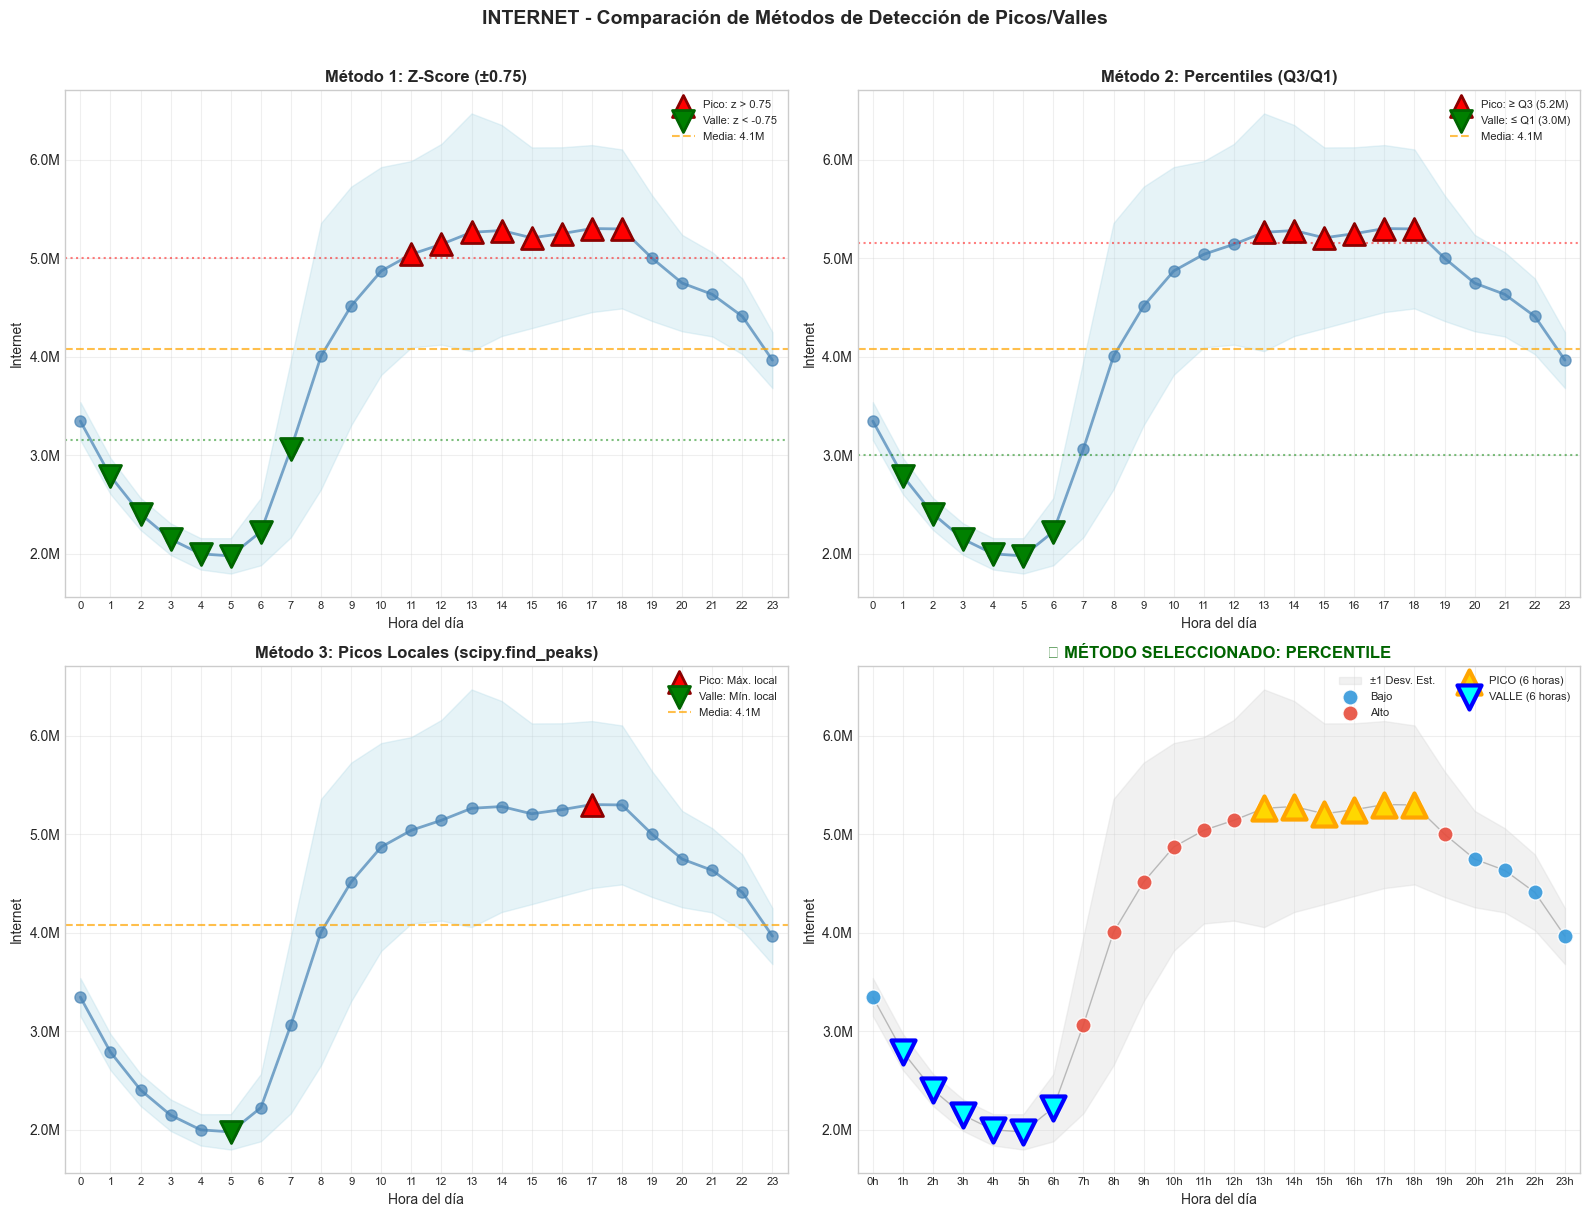


✅ Figura guardada: results/internet_comparacion_picos.png


In [223]:
# =============================================================================
# VISUALIZACIÓN: Comparación de métodos de detección de picos
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

hours = df_daily['hour_of_day'].values
internet = df_daily['internet_mean'].values

# Función auxiliar para graficar perfil
def plot_profile_with_peaks(ax, title, peak_col, valley_col, peak_label, valley_label):
    # Banda de variabilidad
    ax.fill_between(hours, 
                    df_daily['internet_mean'] - df_daily['internet_std'],
                    df_daily['internet_mean'] + df_daily['internet_std'],
                    color='lightblue', alpha=0.3)
    
    # Línea principal
    ax.plot(hours, internet, 'o-', color='steelblue', linewidth=2, markersize=8, alpha=0.7)
    
    # Marcar picos
    picos = df_daily[df_daily[peak_col] == 1]
    ax.scatter(picos['hour_of_day'], picos['internet_mean'],
               marker='^', c='red', s=250, zorder=5, edgecolors='darkred', linewidths=2,
               label=f'Pico: {peak_label}')
    
    # Marcar valles
    valles = df_daily[df_daily[valley_col] == 1]
    ax.scatter(valles['hour_of_day'], valles['internet_mean'],
               marker='v', c='green', s=250, zorder=5, edgecolors='darkgreen', linewidths=2,
               label=f'Valle: {valley_label}')
    
    # Líneas horizontales de referencia
    ax.axhline(y=mean_internet, color='orange', linestyle='--', alpha=0.7, label=f'Media: {mean_internet/1e6:.1f}M')
    
    ax.set_xlabel('Hora del día', fontsize=10)
    ax.set_ylabel('Internet', fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(range(24))
    ax.set_xticklabels([f'{h}' for h in range(24)], fontsize=8)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.5, 23.5)

# Plot 1: Z-Score (threshold = 0.75)
df_daily['temp_peak_z075'] = (df_daily['internet_zscore'] > 0.75).astype(int)
df_daily['temp_valley_z075'] = (df_daily['internet_zscore'] < -0.75).astype(int)
plot_profile_with_peaks(axes[0,0], 'Método 1: Z-Score (±0.75)', 
                        'temp_peak_z075', 'temp_valley_z075', 'z > 0.75', 'z < -0.75')

# Añadir líneas de threshold
axes[0,0].axhline(y=mean_internet + 0.75*std_internet, color='red', linestyle=':', alpha=0.5)
axes[0,0].axhline(y=mean_internet - 0.75*std_internet, color='green', linestyle=':', alpha=0.5)

# Plot 2: Percentiles (P75/P25)
plot_profile_with_peaks(axes[0,1], 'Método 2: Percentiles (Q3/Q1)',
                        'is_peak_p75', 'is_valley_p25', f'≥ Q3 ({p75/1e6:.1f}M)', f'≤ Q1 ({p25/1e6:.1f}M)')
axes[0,1].axhline(y=p75, color='red', linestyle=':', alpha=0.5)
axes[0,1].axhline(y=p25, color='green', linestyle=':', alpha=0.5)

# Plot 3: Picos locales (scipy)
plot_profile_with_peaks(axes[1,0], 'Método 3: Picos Locales (scipy.find_peaks)',
                        'is_peak_local', 'is_valley_local', 'Máx. local', 'Mín. local')

# Plot 4: Método seleccionado (con perfiles coloreados)
ax4 = axes[1,1]
ax4.fill_between(hours, 
                df_daily['internet_mean'] - df_daily['internet_std'],
                df_daily['internet_mean'] + df_daily['internet_std'],
                color='lightgray', alpha=0.3, label='±1 Desv. Est.')

# Colorear por perfil
for perfil in perfiles_presentes:
    mask = df_daily['perfil_internet'] == perfil
    color = colores_perfil.get(perfil, 'gray')
    ax4.scatter(df_daily.loc[mask, 'hour_of_day'], 
                df_daily.loc[mask, 'internet_mean'],
                c=color, s=120, alpha=0.9, edgecolors='white', linewidths=1,
                label=perfil, zorder=3)

ax4.plot(hours, internet, color='gray', linewidth=1, alpha=0.5, zorder=1)

# Marcar picos/valles seleccionados
picos_sel = df_daily[df_daily['is_peak_internet'] == 1]
valles_sel = df_daily[df_daily['is_valley_internet'] == 1]
ax4.scatter(picos_sel['hour_of_day'], picos_sel['internet_mean'],
            marker='^', c='gold', s=300, zorder=5, edgecolors='orange', linewidths=3,
            label=f'PICO ({len(picos_sel)} horas)')
ax4.scatter(valles_sel['hour_of_day'], valles_sel['internet_mean'],
            marker='v', c='cyan', s=300, zorder=5, edgecolors='blue', linewidths=3,
            label=f'VALLE ({len(valles_sel)} horas)')

ax4.set_xlabel('Hora del día', fontsize=10)
ax4.set_ylabel('Internet', fontsize=10)
ax4.set_title(f'✅ MÉTODO SELECCIONADO: {PEAK_METHOD.upper()}', fontsize=12, fontweight='bold', color='darkgreen')
ax4.set_xticks(range(24))
ax4.set_xticklabels([f'{h}h' for h in range(24)], fontsize=8)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
ax4.legend(loc='upper right', fontsize=8, ncol=2)
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-0.5, 23.5)

plt.suptitle('INTERNET - Comparación de Métodos de Detección de Picos/Valles', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'internet_comparacion_picos.png', dpi=150, bbox_inches='tight')
plt.show()

# Limpiar columnas temporales
df_daily.drop(columns=['temp_peak_z075', 'temp_valley_z075'], inplace=True, errors='ignore')

print(f"\n✅ Figura guardada: results/internet_comparacion_picos.png")

In [224]:
# =============================================================================
# TABLA RESUMEN: Comparación de métodos de detección de picos
# =============================================================================

print("=" * 90)
print("📊 RESUMEN COMPARATIVO DE MÉTODOS DE DETECCIÓN DE PICOS/VALLES")
print("=" * 90)

# Crear tabla comparativa
metodos_comparacion = []

# Método 1: Z-Score con diferentes thresholds
for th in [0.5, 0.75, 1.0]:
    picos = df_daily[df_daily['internet_zscore'] > th]['hour_of_day'].tolist()
    valles = df_daily[df_daily['internet_zscore'] < -th]['hour_of_day'].tolist()
    metodos_comparacion.append({
        'Método': f'Z-Score (±{th})',
        'Picos (n)': len(picos),
        'Horas Pico': str(picos),
        'Valles (n)': len(valles),
        'Horas Valle': str(valles),
        'Pros': 'Estadísticamente fundamentado',
        'Contras': 'Sensible a distribución'
    })

# Método 2: Percentiles
metodos_comparacion.append({
    'Método': 'Percentiles (Q3/Q1)',
    'Picos (n)': df_daily['is_peak_p75'].sum(),
    'Horas Pico': str(df_daily[df_daily['is_peak_p75']==1]['hour_of_day'].tolist()),
    'Valles (n)': df_daily['is_valley_p25'].sum(),
    'Horas Valle': str(df_daily[df_daily['is_valley_p25']==1]['hour_of_day'].tolist()),
    'Pros': 'Robusto a outliers',
    'Contras': 'Siempre 25% en cada grupo'
})

metodos_comparacion.append({
    'Método': 'Percentiles (P90/P10)',
    'Picos (n)': df_daily['is_peak_p90'].sum(),
    'Horas Pico': str(df_daily[df_daily['is_peak_p90']==1]['hour_of_day'].tolist()),
    'Valles (n)': df_daily['is_valley_p10'].sum(),
    'Horas Valle': str(df_daily[df_daily['is_valley_p10']==1]['hour_of_day'].tolist()),
    'Pros': 'Más selectivo',
    'Contras': 'Puede omitir horas relevantes'
})

# Método 3: Picos locales
metodos_comparacion.append({
    'Método': 'Picos Locales (scipy)',
    'Picos (n)': df_daily['is_peak_local'].sum(),
    'Horas Pico': str(df_daily[df_daily['is_peak_local']==1]['hour_of_day'].tolist()),
    'Valles (n)': df_daily['is_valley_local'].sum(),
    'Horas Valle': str(df_daily[df_daily['is_valley_local']==1]['hour_of_day'].tolist()),
    'Pros': 'Detecta cambios locales',
    'Contras': 'No considera magnitud global'
})

df_comparacion = pd.DataFrame(metodos_comparacion)
display(df_comparacion[['Método', 'Picos (n)', 'Horas Pico', 'Valles (n)', 'Horas Valle']])

print("\n💡 RECOMENDACIÓN:")
print("   - Para patrones GLOBALES: Usar Percentiles (Q3/Q1) - siempre da 25% en cada categoría")
print("   - Para extremos ABSOLUTOS: Usar Z-Score (±1.0) - solo valores muy alejados de la media")
print("   - Para patrones TEMPORALES: Usar Picos Locales - detecta subidas/bajadas relativas")
print(f"\n🎯 MÉTODO ACTUAL SELECCIONADO: {PEAK_METHOD.upper()}")

📊 RESUMEN COMPARATIVO DE MÉTODOS DE DETECCIÓN DE PICOS/VALLES


,Método,Picos (n),Horas Pico,Valles (n),Horas Valle
0,Z-Score (±0.5),11,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]",8,"[0, 1, 2, 3, 4, 5, 6, 7]"
1,Z-Score (±0.75),8,"[11, 12, 13, 14, 15, 16, 17, 18]",7,"[1, 2, 3, 4, 5, 6, 7]"
2,Z-Score (±1.0),0,[],6,"[1, 2, 3, 4, 5, 6]"
3,Percentiles (Q3/Q1),6,"[13, 14, 15, 16, 17, 18]",6,"[1, 2, 3, 4, 5, 6]"
4,Percentiles (P90/P10),3,"[14, 17, 18]",3,"[3, 4, 5]"
5,Picos Locales (scipy),1,[17],1,[5]



💡 RECOMENDACIÓN:
   - Para patrones GLOBALES: Usar Percentiles (Q3/Q1) - siempre da 25% en cada categoría
   - Para extremos ABSOLUTOS: Usar Z-Score (±1.0) - solo valores muy alejados de la media
   - Para patrones TEMPORALES: Usar Picos Locales - detecta subidas/bajadas relativas

🎯 MÉTODO ACTUAL SELECCIONADO: PERCENTILE


## Paso 20: Exportar tabla lookup de INTERNET
Exportamos el perfil horario de Internet con clusters y features para transferencia.

In [226]:
# =============================================================================
# PASO 20: Exportar tabla lookup de INTERNET
# =============================================================================

# Columnas para exportar
export_cols_internet = [
    'hour_of_day',
    'internet_mean',
    'internet_std',
    'internet_cv',
    'cluster_internet',
    'perfil_internet',
    'internet_zscore',
    'is_peak_internet',
    'is_valley_internet',
    'pca_internet_1',
    'pca_internet_2'
]

# Crear DataFrame de exportación
df_internet_export = df_daily[export_cols_internet].copy()
df_internet_export = df_internet_export.sort_values('hour_of_day').reset_index(drop=True)

# Exportar
export_path = RESULTS_DIR / 'internet_profile_features.csv'
df_internet_export.to_csv(export_path, index=False)

print("=" * 80)
print("EXPORTACIÓN DE FEATURES DE INTERNET")
print("=" * 80)
print(f"\n✅ Archivo exportado: {export_path}")
print(f"   Filas: {len(df_internet_export)} (24 horas)")
print(f"   Columnas: {len(df_internet_export.columns)}")

print("\n📋 Columnas exportadas:")
for col in df_internet_export.columns:
    print(f"   - {col}")

print("\n📊 Vista previa:")
display(df_internet_export.head(10))

# =============================================================================
# Guardar reporte interpretado (como en experiments.ipynb)
# =============================================================================
with open(RESULTS_DIR / 'internet_patrones_horarios.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("ANÁLISIS DE CLUSTERING - INTERNET (DATOS MÓVILES)\n")
    f.write("=" * 80 + "\n\n")
    
    f.write(f"K óptimo seleccionado: {K_INTERNET})\n")
    f.write(f"Método: 30 repeticiones de K-Means para cada K\n\n")
    
    f.write("PERFILES IDENTIFICADOS:\n")
    f.write("-" * 60 + "\n")
    for perfil in perfiles_presentes:
        horas = df_daily[df_daily['perfil_internet'] == perfil]['hour_of_day'].tolist()
        media = df_daily[df_daily['perfil_internet'] == perfil]['internet_mean'].mean()
        part = perfil_summary.loc[perfil, 'participacion_pct']
        f.write(f"\n{perfil}:\n")
        f.write(f"  Horas: {horas}\n")
        f.write(f"  Internet medio: {media:,.0f}\n")
        f.write(f"  Participación tráfico: {part:.1f}%\n")
    
    f.write("\n\nHORAS PICO:\n")
    f.write("-" * 60 + "\n")
    for h in horas_pico:
        row = df_daily[df_daily['hour_of_day'] == h].iloc[0]
        f.write(f"  {h}h: Internet = {row['internet_mean']:,.0f} (z = {row['internet_zscore']:.2f})\n")
    
    f.write("\n\nHORAS VALLE:\n")
    f.write("-" * 60 + "\n")
    for h in horas_valle:
        row = df_daily[df_daily['hour_of_day'] == h].iloc[0]
        f.write(f"  {h}h: Internet = {row['internet_mean']:,.0f} (z = {row['internet_zscore']:.2f})\n")

print(f"\n✅ Reporte guardado: results/internet_patrones_horarios.txt")

EXPORTACIÓN DE FEATURES DE INTERNET

✅ Archivo exportado: results\internet_profile_features.csv
   Filas: 24 (24 horas)
   Columnas: 11

📋 Columnas exportadas:
   - hour_of_day
   - internet_mean
   - internet_std
   - internet_cv
   - cluster_internet
   - perfil_internet
   - internet_zscore
   - is_peak_internet
   - is_valley_internet
   - pca_internet_1
   - pca_internet_2

📊 Vista previa:


,hour_of_day,internet_mean,internet_std,internet_cv,cluster_internet,perfil_internet,internet_zscore,is_peak_internet,is_valley_internet,pca_internet_1,pca_internet_2
0,0,3.347634e+06,1.928863e+05,0.057619,1,Bajo,-0.593332,0,0,-1.786676,0.364357
1,1,2.789541e+06,1.834284e+05,0.065756,1,Bajo,-1.045482,0,1,-1.973587,-0.066591
2,2,2.405005e+06,1.624827e+05,0.067560,1,Bajo,-1.357022,0,1,-2.154738,-0.330542
3,3,2.148474e+06,1.599294e+05,0.074439,1,Bajo,-1.564856,0,1,-2.214103,-0.553142
4,4,1.999222e+06,1.591296e+05,0.079596,1,Bajo,-1.685775,0,1,-2.238827,-0.691684
5,5,1.978550e+06,1.796648e+05,0.090806,1,Bajo,-1.702523,0,1,-2.129312,-0.796783
6,6,2.224967e+06,3.420236e+05,0.153721,1,Bajo,-1.502884,0,1,-1.286068,-1.158184
7,7,3.067714e+06,8.991376e+05,0.293097,0,Alto,-0.820114,0,0,1.031066,-1.814248
8,8,4.008188e+06,1.352073e+06,0.337328,0,Alto,-0.058170,0,0,2.501901,-1.648785
9,9,4.517264e+06,1.211428e+06,0.268177,0,Alto,0.354269,0,0,1.962296,-0.742993



✅ Reporte guardado: results/internet_patrones_horarios.txt


---

## 📊 Resumen - Análisis de INTERNET (Datos)

### Metodología aplicada
- **Selección de K**: 30 repeticiones de K-Means por cada K∈[2,7]
- **Métrica**: Silhouette Score (media ± std)
- **Mapeo**: Dinámico a perfiles Bajo/Normal/Alto basado en media

### Features generadas

| Columna | Descripción |
|---------|-------------|
| `internet_mean` | Tráfico promedio por hora |
| `internet_std` | Variabilidad inter-día |
| `internet_cv` | Coeficiente de variación |
| `cluster_internet` | ID del cluster asignado |
| `perfil_internet` | Perfil interpretado (Bajo/Normal/Alto) |
| `internet_zscore` | Puntuación normalizada |
| `is_peak_internet` | Flag hora pico |
| `is_valley_internet` | Flag hora valle |

### Archivos generados
- `results/internet_profile_features.csv` - Tabla lookup
- `results/internet_k_selection_robust.png` - Selección de K
- `results/internet_clusters_lineal_log.png` - Clusters LINEAL vs LOG
- `results/internet_perfiles_boxplots.png` - Boxplots por perfil
- `results/internet_participacion_trafico.png` - Participación en tráfico
- `results/internet_heatmap_pca.png` - Heatmap y PCA
- `results/internet_perfil_picos_valles.png` - Perfil con picos/valles
- `results/internet_patrones_horarios.txt` - Reporte textual